In [6]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 32768 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen3-0.6B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    full_finetuning = True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 05-20 05:30:21 [importing.py:53] Triton module has been replaced with a placeholder.


INFO 05-20 05:30:21 [__init__.py:239] Automatically detected platform cuda.


2025-05-20 05:30:23,829	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Float16 full finetuning uses more memory since we upcast weights to float32.


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'smart_contract_train.csv',
    'val': 'smart_contract_val.csv',
    'test': 'smart_contract_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)


Generating train split: 0 examples [00:00, ? examples/s]


Generating train split: 1324 examples [00:00, 40775.82 examples/s]


Generating val split: 0 examples [00:00, ? examples/s]


Generating val split: 281 examples [00:00, 28025.19 examples/s]


Generating test split: 0 examples [00:00, ? examples/s]


Generating test split: 278 examples [00:00, 29713.48 examples/s]

In [ ]:
import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world.""",
    """You are the greatest AI assistant smart contract security auditor in the world.""",
    """You are the best solidity smart contract security auditor in the world""",
    """You are the greatest AI assistant solidity security researcher in the world""",
    """You are the best AI solidity smart contract security auditor in the world."""
]

PROMPTS = [
    """You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.
    
    This is the function we need to audit:
    ```solidity
    {code}
    ```
    
Answer: """,
    
    """Analyze the given function and determine whether it is "Vulnerable Code" or "Safe Code" based on security risks.
    
    Function to audit:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Examine the Solidity function below and assess if it is "Vulnerable Code" or "Safe Code."
    
    Solidity Function:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Review the Solidity function and classify it as "Vulnerable Code" or "Safe Code" by checking for security issues.
    
    Solidity Function:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Audit the given Solidity function to determine if it should be categorized as "Vulnerable Code" or "Safe Code."
    
    Solidity Code:
    ```solidity
    {code}
    ```
    
Answer: """,
]


def make_conversational(examples, system_prompt, prompt):
    code = examples['code']
    vulnerable = "Vulnerable Code" if examples['vulnerable'] == 1 else "Safe Code"
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(code=code)},
                    {"role": "assistant", "content": vulnerable}]
    
    return { "conversations" : conversation}

# List of splits you want to process
splits = ['train', 'val', 'test']

# Dictionary to store concatenated datasets for each split
concatenated_datasets = {split: [] for split in splits}

# Process each dataset
for i in range(5):
    system_prompt = SYSTEM_PROMPT[i]
    prompt = PROMPTS[i]
    
    # Create a new dataset using map
    new_dataset = dataset.map(lambda ex: make_conversational(ex, system_prompt, prompt))
    
    # Append the correct split of the new dataset to the corresponding list
    for split in splits:
        concatenated_datasets[split].append(new_dataset[split])

# Now concatenate all datasets for each split
dataset = DatasetDict({
    split: concatenate_datasets(concatenated_datasets[split]).shuffle(seed=42) for split in splits
})

dataset = dataset.remove_columns(["project_id","code", "code_analysis", "vulnerable"])


Map:   0%|                                                                                 | 0/1324 [00:00<?, ? examples/s]


Map:  74%|███████████████████████████████████████████████████▎                 | 984/1324 [00:00<00:00, 9693.37 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 7703.05 examples/s]


Map:   0%|                                                                                  | 0/281 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 7235.47 examples/s]


Map:   0%|                                                                                  | 0/278 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 7390.94 examples/s]


Map:   0%|                                                                                 | 0/1324 [00:00<?, ? examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 1000/1324 [00:00<00:00, 8255.16 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 8105.56 examples/s]


Map:   0%|                                                                                  | 0/281 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 7266.33 examples/s]


Map:   0%|                                                                                  | 0/278 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 7453.49 examples/s]


Map:   0%|                                                                                 | 0/1324 [00:00<?, ? examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 1000/1324 [00:00<00:00, 8177.18 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 7904.83 examples/s]


Map:   0%|                                                                                  | 0/281 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 6111.10 examples/s]


Map:   0%|                                                                                  | 0/278 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 6225.56 examples/s]


Map:   0%|                                                                                 | 0/1324 [00:00<?, ? examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 1000/1324 [00:00<00:00, 8092.25 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 8015.20 examples/s]


Map:   0%|                                                                                  | 0/281 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 7528.87 examples/s]


Map:   0%|                                                                                  | 0/278 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 7522.20 examples/s]


Map:   0%|                                                                                 | 0/1324 [00:00<?, ? examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 1000/1324 [00:00<00:00, 8491.96 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 8351.86 examples/s]


Map:   0%|                                                                                  | 0/281 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 7506.48 examples/s]


Map:   0%|                                                                                  | 0/278 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 7364.89 examples/s]

In [ ]:
from unsloth.chat_templates import get_chat_template

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False, enable_thinking=False) for convo in convos]
    return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True,)


Map:   0%|                                                                                 | 0/6620 [00:00<?, ? examples/s]


Map:  15%|██████████▎                                                         | 1000/6620 [00:00<00:01, 3130.85 examples/s]


Map:  30%|████████████████████▌                                               | 2000/6620 [00:00<00:01, 3439.63 examples/s]


Map:  45%|██████████████████████████████▊                                     | 3000/6620 [00:00<00:01, 3386.97 examples/s]


Map:  60%|█████████████████████████████████████████                           | 4000/6620 [00:01<00:00, 3476.48 examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 5000/6620 [00:01<00:00, 3553.77 examples/s]


Map:  91%|█████████████████████████████████████████████████████████████▋      | 6000/6620 [00:01<00:00, 3609.70 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 6620/6620 [00:01<00:00, 3473.91 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 6620/6620 [00:01<00:00, 3464.16 examples/s]


Map:   0%|                                                                                 | 0/1405 [00:00<?, ? examples/s]


Map:  71%|████████████████████████████████████████████████▍                   | 1000/1405 [00:00<00:00, 3634.72 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1405/1405 [00:00<00:00, 3640.92 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1405/1405 [00:00<00:00, 3611.00 examples/s]


Map:   0%|                                                                                 | 0/1390 [00:00<?, ? examples/s]


Map:  72%|████████████████████████████████████████████████▉                   | 1000/1390 [00:00<00:00, 3687.20 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1390/1390 [00:00<00:00, 3677.56 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1390/1390 [00:00<00:00, 3645.33 examples/s]

In [11]:
dataset['train'][5]["conversations"]

[{'content': 'You are the smartest AI solidity smart contract security auditor in the world.',
  'role': 'system'},
 {'content': 'You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function withdraw(uint256 tokenId) external override {\n        require(\n            _msgSender() == ownerOf(tokenId),\n            "ChildMintableERC721: INVALID_TOKEN_OWNER"\n        );\n        withdrawnTokens[tokenId] = true;\n        _burn(tokenId);\n    }\n    ```\n    \nAnswer: ',
  'role': 'user'},
 {'content': 'Vulnerable Code', 'role': 'assistant'}]

In [12]:
dataset['train'][5]["text"]

'<|im_start|>system\nYou are the smartest AI solidity smart contract security auditor in the world.<|im_end|>\n<|im_start|>user\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function withdraw(uint256 tokenId) external override {\n        require(\n            _msgSender() == ownerOf(tokenId),\n            "ChildMintableERC721: INVALID_TOKEN_OWNER"\n        );\n        withdrawnTokens[tokenId] = true;\n        _burn(tokenId);\n    }\n    ```\n    \nAnswer: <|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nVulnerable Code<|im_end|>\n'

In [13]:
tokenized = dataset['train'].map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["conversations"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
# print(tokenizer.decode(tokenized[0]["tokens"]))
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Train Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
dataset['train'] = dataset['train'].select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized


Map:   0%|                                                                                 | 0/6620 [00:00<?, ? examples/s]


Map:  15%|██████████▎                                                         | 1000/6620 [00:00<00:03, 1760.51 examples/s]


Map:  30%|████████████████████▌                                               | 2000/6620 [00:01<00:02, 1943.85 examples/s]


Map:  45%|██████████████████████████████▊                                     | 3000/6620 [00:01<00:01, 1965.02 examples/s]


Map:  60%|█████████████████████████████████████████                           | 4000/6620 [00:02<00:01, 2029.45 examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 5000/6620 [00:02<00:00, 2015.03 examples/s]


Map:  91%|█████████████████████████████████████████████████████████████▋      | 6000/6620 [00:02<00:00, 2064.54 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 6620/6620 [00:03<00:00, 1893.53 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 6620/6620 [00:03<00:00, 1945.52 examples/s]


Map:   0%|                                                                                 | 0/6620 [00:00<?, ? examples/s]


Map:   4%|██▊                                                                  | 267/6620 [00:00<00:02, 2518.93 examples/s]


Map:   9%|██████▎                                                              | 605/6620 [00:00<00:02, 2336.95 examples/s]


Map:  13%|████████▊                                                            | 844/6620 [00:00<00:02, 2353.20 examples/s]


Map:  17%|███████████▍                                                        | 1112/6620 [00:00<00:03, 1821.64 examples/s]


Map:  21%|██████████████                                                      | 1368/6620 [00:00<00:02, 2018.63 examples/s]


Map:  24%|████████████████▍                                                   | 1604/6620 [00:00<00:02, 2087.12 examples/s]


Map:  28%|███████████████████▏                                                | 1868/6620 [00:00<00:02, 2243.01 examples/s]


Map:  32%|█████████████████████▉                                              | 2134/6620 [00:01<00:02, 1844.49 examples/s]


Map:  36%|████████████████████████▏                                           | 2360/6620 [00:01<00:02, 1943.33 examples/s]


Map:  40%|██████████████████████████▉                                         | 2628/6620 [00:01<00:01, 2129.89 examples/s]


Map:  43%|█████████████████████████████▌                                      | 2879/6620 [00:01<00:01, 2228.08 examples/s]


Map:  47%|████████████████████████████████▎                                   | 3141/6620 [00:01<00:01, 1936.71 examples/s]


Map:  51%|██████████████████████████████████▉                                 | 3404/6620 [00:01<00:01, 2104.44 examples/s]


Map:  55%|█████████████████████████████████████▌                              | 3659/6620 [00:01<00:01, 2216.93 examples/s]


Map:  59%|████████████████████████████████████████▏                           | 3909/6620 [00:01<00:01, 2289.90 examples/s]


Map:  63%|██████████████████████████████████████████▌                         | 4147/6620 [00:02<00:01, 1927.59 examples/s]


Map:  67%|█████████████████████████████████████████████▍                      | 4427/6620 [00:02<00:01, 2061.97 examples/s]


Map:  72%|████████████████████████████████████████████████▊                   | 4754/6620 [00:02<00:00, 2094.22 examples/s]


Map:  76%|███████████████████████████████████████████████████▎                | 5000/6620 [00:02<00:00, 1805.29 examples/s]


Map:  80%|██████████████████████████████████████████████████████▋             | 5319/6620 [00:02<00:00, 1899.84 examples/s]


Map:  85%|█████████████████████████████████████████████████████████▌          | 5608/6620 [00:02<00:00, 2117.94 examples/s]


Map:  88%|███████████████████████████████████████████████████████████▉        | 5839/6620 [00:02<00:00, 2162.64 examples/s]


Map:  93%|███████████████████████████████████████████████████████████████     | 6134/6620 [00:02<00:00, 1953.13 examples/s]


Map:  97%|█████████████████████████████████████████████████████████████████▋  | 6393/6620 [00:03<00:00, 2098.42 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 6620/6620 [00:03<00:00, 2135.73 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 6620/6620 [00:03<00:00, 2035.48 examples/s]

Train Max Length =  674


In [14]:
tokenized = dataset['val'].map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["conversations"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Val Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
dataset['val'] = dataset['val'].select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized


Map:   0%|                                                                                 | 0/1405 [00:00<?, ? examples/s]


Map:  71%|████████████████████████████████████████████████▍                   | 1000/1405 [00:00<00:00, 2064.91 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1405/1405 [00:00<00:00, 2075.23 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1405/1405 [00:00<00:00, 2057.76 examples/s]


Map:   0%|                                                                                 | 0/1405 [00:00<?, ? examples/s]


Map:  17%|███████████▊                                                         | 240/1405 [00:00<00:00, 2366.60 examples/s]


Map:  36%|████████████████████████▋                                            | 503/1405 [00:00<00:00, 2471.86 examples/s]


Map:  63%|███████████████████████████████████████████▏                         | 879/1405 [00:00<00:00, 2446.20 examples/s]


Map:  88%|███████████████████████████████████████████████████████████▊        | 1237/1405 [00:00<00:00, 1839.28 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████████| 1405/1405 [00:00<00:00, 1945.25 examples/s]

Val Max Length =  612


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

train_dataset = dataset['train']
val_dataset = dataset['val']

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 4,
    packing = False, 
    args = TrainingArguments(
        eval_strategy="steps",
        eval_steps=100,
        save_steps=100,
        per_device_train_batch_size = 8,
        per_device_eval_batch_size = 8,
        gradient_accumulation_steps = 1, 
        warmup_ratio = 0.1,
        num_train_epochs = 10, 
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit", 
        weight_decay= 1.0,
        lr_scheduler_type = "cosine",
        seed = 3407,
        load_best_model_at_end=True,
        output_dir = "outputs_dedup_v6_explore",
        report_to = "none", 
    ),
)


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|                                           | 0/5958 [00:00<?, ? examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  17%|█████▏                         | 1000/5958 [00:01<00:08, 591.19 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  34%|██████████                    | 2000/5958 [00:01<00:03, 1290.16 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  50%|███████████████               | 3000/5958 [00:01<00:01, 2125.07 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  67%|████████████████████▏         | 4000/5958 [00:02<00:00, 3054.47 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  84%|█████████████████████████     | 4980/5958 [00:02<00:00, 3060.62 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4): 100%|██████████████████████████████| 5958/5958 [00:02<00:00, 3233.75 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4): 100%|██████████████████████████████| 5958/5958 [00:02<00:00, 2179.97 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|                                           | 0/1264 [00:00<?, ? examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  25%|████████                        | 316/1264 [00:01<00:03, 287.19 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  50%|████████████████                | 632/1264 [00:01<00:01, 616.85 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  75%|████████████████████████        | 948/1264 [00:01<00:00, 938.79 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4): 100%|███████████████████████████████| 1264/1264 [00:01<00:00, 832.01 examples/s]

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [16]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part = "<|im_start|>assistant\n",
)


Map (num_proc=80):   0%|                                                                   | 0/5958 [00:00<?, ? examples/s]


Map (num_proc=80):   1%|▋                                                        | 75/5958 [00:00<00:14, 416.84 examples/s]


Map (num_proc=80):   5%|██▊                                                    | 300/5958 [00:00<00:04, 1225.95 examples/s]


Map (num_proc=80):  10%|█████▌                                                 | 600/5958 [00:00<00:02, 1833.37 examples/s]


Map (num_proc=80):  14%|███████▌                                               | 825/5958 [00:00<00:03, 1540.57 examples/s]


Map (num_proc=80):  50%|███████████████████████████▏                          | 2998/5958 [00:00<00:00, 7114.45 examples/s]


Map (num_proc=80):  80%|██████████████████████████████████████████▍          | 4774/5958 [00:00<00:00, 10029.50 examples/s]


Map (num_proc=80): 100%|██████████████████████████████████████████████████████| 5958/5958 [00:00<00:00, 6347.17 examples/s]


Map (num_proc=80):   0%|                                                                   | 0/1264 [00:00<?, ? examples/s]


Map (num_proc=80):   1%|▋                                                        | 16/1264 [00:00<00:10, 122.22 examples/s]


Map (num_proc=80):   5%|██▉                                                      | 64/1264 [00:00<00:05, 212.70 examples/s]


Map (num_proc=80):   8%|████▎                                                    | 96/1264 [00:00<00:05, 216.75 examples/s]


Map (num_proc=80):  23%|████████████▊                                           | 288/1264 [00:00<00:01, 711.25 examples/s]


Map (num_proc=80):  66%|████████████████████████████████████▏                  | 832/1264 [00:00<00:00, 2090.09 examples/s]


Map (num_proc=80): 100%|██████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 1511.38 examples/s]

In [17]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|im_start|>system\nYou are the smartest AI solidity smart contract security auditor in the world.<|im_end|>\n<|im_start|>user\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function withdraw(uint256 tokenId) external override {\n        require(\n            _msgSender() == ownerOf(tokenId),\n            "ChildMintableERC721: INVALID_TOKEN_OWNER"\n        );\n        withdrawnTokens[tokenId] = true;\n        _burn(tokenId);\n    }\n    ```\n    \nAnswer: <|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nVulnerable Code<|im_end|>\n'

In [18]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                                                         <think>\n\n</think>\n\nVulnerable Code<|im_end|>\n'

In [19]:
tokenizer.decode(trainer.eval_dataset[5]["input_ids"])

'<|im_start|>system\nYou are the best solidity smart contract security auditor in the world<|im_end|>\n<|im_start|>user\nExamine the Solidity function below and assess if it is "Vulnerable Code" or "Safe Code."\n    \n    Solidity Function:\n    ```solidity\n    function withdrawFrom(\n    address from,\n    address payable to,\n    uint256 amount\n  ) external {\n    if (amount == 0) {\n      revert FETH_No_Funds_To_Withdraw();\n    }\n    AccountInfo storage accountInfo = _freeFromEscrow(from);\n    if (from != msg.sender) {\n      _deductAllowanceFrom(accountInfo, amount);\n    }\n    _deductBalanceFrom(accountInfo, amount);\n\n    // With the external call after state changes, we do not need a nonReentrant guard\n    to.sendValue(amount);\n\n    emit ETHWithdrawn(from, to, amount);\n  }\n    ```\n    \nAnswer: <|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nVulnerable Code<|im_end|>\n'

In [20]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.eval_dataset[5]["labels"]])

'                                                                                                                                                                                                      <think>\n\n</think>\n\nVulnerable Code<|im_end|>\n'

In [ ]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,958 | Num Epochs = 10 | Total steps = 7,450
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 596,049,920/596,049,920 (100.00% trained)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
100,0.022200,0.054024
200,0.001900,0.066219
300,0.054200,0.072333
400,0.050200,0.056152
500,0.027200,0.050881
600,0.000200,0.073931
700,0.023400,0.056964
800,0.021900,0.106440
900,0.005600,0.067942
1000,0.146700,0.223650


Unsloth: Will smartly offload gradients to save VRAM!


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


In [ ]:
from unsloth.chat_templates import get_chat_template

FastLanguageModel.for_inference(model) 

messages = test_dataset['conversations'][1]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    enable_thinking=False,
    add_generation_prompt = True, 
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|im_start|>system\nYou are the smartest AI solidity smart contract security auditor in the world.<|im_end|>\n<|im_start|>user\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function _getAdmin(uint256 adminEpoch, uint256 index) internal view returns (address) {\n        return getAddress(_getAdminKey(adminEpoch, index));\n    }\n\nfunction _isAdmin(uint256 adminEpoch, address account) internal view returns (bool) {\n        return getBool(_getIsAdminKey(adminEpoch, account));\n    }\n\nfunction _setAdminEpoch(uint256 adminEpoch) internal {\n        _setUint(KEY_ADMIN_EPOCH, adminEpoch);\n    }\n    ```\n    \nAnswer: <|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nSafe Code<|im_end|>']

In [ ]:
model.save_pretrained("ours_detector") 
tokenizer.save_pretrained("ours_detector")

In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'smart_contract_train.csv',
    'val': 'smart_contract_val.csv',
    'test': 'smart_contract_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world.""",
    """You are the greatest AI assistant smart contract security auditor in the world.""",
    """You are the best solidity smart contract security auditor in the world""",
    """You are the greatest AI assistant solidity security researcher in the world""",
    """You are the best AI solidity smart contract security auditor in the world."""
]

PROMPTS = [
    """You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.
    
    This is the function we need to audit:
    ```solidity
    {code}
    ```
    
Answer: """,
    
    """Analyze the given function and determine whether it is "Vulnerable Code" or "Safe Code" based on security risks.
    
    Function to audit:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Examine the Solidity function below and assess if it is "Vulnerable Code" or "Safe Code."
    
    Solidity Function:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Review the Solidity function and classify it as "Vulnerable Code" or "Safe Code" by checking for security issues.
    
    Solidity Function:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Audit the given Solidity function to determine if it should be categorized as "Vulnerable Code" or "Safe Code."
    
    Solidity Code:
    ```solidity
    {code}
    ```
    
Answer: """,
]

def make_conversational_vote(examples, system_prompt, prompt):
    code = examples['code']
    vulnerable = "Vulnerable Code" if examples['vulnerable'] == 1 else "Safe Code"
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt.format(code=code)}
    ]
    return {"conversations": conversation, "label": vulnerable}

# Generate 5 datasets using different prompts
datasets = []
for i in range(len(PROMPTS)):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, SYSTEM_PROMPT[i], PROMPTS[i]))
    new_dataset = new_dataset.remove_columns(["project_id", "code", "code_analysis", "vulnerable"])
    datasets.append(new_dataset)

In [32]:
# Inference with majority voting
pattern = r"<\|im_start\|>assistant\n<think>\n\n</think>\n\n(.*?)<\|im_end\|>"
y_preds = [[] for _ in range(5)]

for i, dataset in enumerate(datasets):
    for messages in tqdm(dataset['test']['conversations']):
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            enable_thinking=False,
            add_generation_prompt=True,
            return_tensors="pt",
        ).to("cuda")

        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=8,
            use_cache=True,
            temperature=0.1,
            min_p=0.1
        )
        decoded_output = tokenizer.batch_decode(outputs)[0]
        match = re.search(pattern, decoded_output, re.DOTALL)
        extracted_label = match.group(1).strip() if match else "Unknown"
        y_preds[i].append(extracted_label)
        
# Majority voting
final_predictions = []
for preds in zip(*y_preds):
    vote_count = {"Vulnerable Code": 0, "Safe Code": 0}
    for pred in preds:
        if pred in vote_count:
            vote_count[pred] += 1
    final_prediction = max(vote_count, key=vote_count.get)
    final_predictions.append(final_prediction)

print("Final Predictions:", final_predictions)


  0%|                                                                                              | 0/278 [00:00<?, ?it/s]


  0%|▎                                                                                     | 1/278 [00:00<00:57,  4.85it/s]


  1%|▌                                                                                     | 2/278 [00:00<00:55,  4.99it/s]


  1%|▉                                                                                     | 3/278 [00:00<00:55,  5.00it/s]


  1%|█▏                                                                                    | 4/278 [00:00<01:01,  4.45it/s]


  2%|█▌                                                                                    | 5/278 [00:01<00:58,  4.65it/s]


  2%|█▊                                                                                    | 6/278 [00:01<00:57,  4.71it/s]


  3%|██▏                                                                                   | 7/278 [00:01<01:02,  4.34it/s]


  3%|██▍                                                                                   | 8/278 [00:01<00:59,  4.53it/s]


  3%|██▊                                                                                   | 9/278 [00:01<00:57,  4.69it/s]


  4%|███                                                                                  | 10/278 [00:02<00:55,  4.83it/s]


  4%|███▎                                                                                 | 11/278 [00:02<00:59,  4.50it/s]


  4%|███▋                                                                                 | 12/278 [00:02<00:57,  4.66it/s]


  5%|███▉                                                                                 | 13/278 [00:02<00:55,  4.80it/s]


  5%|████▎                                                                                | 14/278 [00:02<00:53,  4.91it/s]


  5%|████▌                                                                                | 15/278 [00:03<00:52,  5.01it/s]


  6%|████▉                                                                                | 16/278 [00:03<00:51,  5.09it/s]


  6%|█████▏                                                                               | 17/278 [00:03<00:55,  4.67it/s]


  6%|█████▌                                                                               | 18/278 [00:03<00:58,  4.42it/s]


  7%|█████▊                                                                               | 19/278 [00:04<01:00,  4.28it/s]


  7%|██████                                                                               | 20/278 [00:04<01:01,  4.20it/s]


  8%|██████▍                                                                              | 21/278 [00:04<00:57,  4.43it/s]


  8%|██████▋                                                                              | 22/278 [00:04<00:55,  4.64it/s]


  8%|███████                                                                              | 23/278 [00:04<00:54,  4.69it/s]


  9%|███████▎                                                                             | 24/278 [00:05<00:57,  4.42it/s]


  9%|███████▋                                                                             | 25/278 [00:05<00:58,  4.30it/s]


  9%|███████▉                                                                             | 26/278 [00:05<01:00,  4.20it/s]


 10%|████████▎                                                                            | 27/278 [00:05<01:00,  4.13it/s]


 10%|████████▌                                                                            | 28/278 [00:06<01:00,  4.10it/s]


 10%|████████▊                                                                            | 29/278 [00:06<00:56,  4.40it/s]


 11%|█████████▏                                                                           | 30/278 [00:06<00:58,  4.28it/s]


 11%|█████████▍                                                                           | 31/278 [00:06<00:54,  4.52it/s]


 12%|█████████▊                                                                           | 32/278 [00:07<00:52,  4.71it/s]


 12%|██████████                                                                           | 33/278 [00:07<00:50,  4.85it/s]


 12%|██████████▍                                                                          | 34/278 [00:07<00:49,  4.97it/s]


 13%|██████████▋                                                                          | 35/278 [00:07<00:48,  5.04it/s]


 13%|███████████                                                                          | 36/278 [00:07<00:47,  5.08it/s]


 13%|███████████▎                                                                         | 37/278 [00:08<00:51,  4.69it/s]


 14%|███████████▌                                                                         | 38/278 [00:08<00:49,  4.85it/s]


 14%|███████████▉                                                                         | 39/278 [00:08<00:48,  4.93it/s]


 14%|████████████▏                                                                        | 40/278 [00:08<00:48,  4.95it/s]


 15%|████████████▌                                                                        | 41/278 [00:08<00:51,  4.60it/s]


 15%|████████████▊                                                                        | 42/278 [00:09<00:49,  4.76it/s]


 15%|█████████████▏                                                                       | 43/278 [00:09<00:48,  4.89it/s]


 16%|█████████████▍                                                                       | 44/278 [00:09<00:51,  4.58it/s]


 16%|█████████████▊                                                                       | 45/278 [00:09<00:49,  4.73it/s]


 17%|██████████████                                                                       | 46/278 [00:09<00:52,  4.45it/s]


 17%|██████████████▎                                                                      | 47/278 [00:10<00:54,  4.24it/s]


 17%|██████████████▋                                                                      | 48/278 [00:10<00:55,  4.13it/s]


 18%|██████████████▉                                                                      | 49/278 [00:10<00:56,  4.07it/s]


 18%|███████████████▎                                                                     | 50/278 [00:10<00:56,  4.05it/s]


 18%|███████████████▌                                                                     | 51/278 [00:11<00:52,  4.33it/s]


 19%|███████████████▉                                                                     | 52/278 [00:11<00:49,  4.57it/s]


 19%|████████████████▏                                                                    | 53/278 [00:11<00:47,  4.74it/s]


 19%|████████████████▌                                                                    | 54/278 [00:11<00:46,  4.87it/s]


 20%|████████████████▊                                                                    | 55/278 [00:11<00:44,  4.96it/s]


 20%|█████████████████                                                                    | 56/278 [00:12<00:48,  4.62it/s]


 21%|█████████████████▍                                                                   | 57/278 [00:12<00:50,  4.38it/s]


 21%|█████████████████▋                                                                   | 58/278 [00:12<00:47,  4.59it/s]


 21%|██████████████████                                                                   | 59/278 [00:12<00:50,  4.38it/s]


 22%|██████████████████▎                                                                  | 60/278 [00:13<00:51,  4.25it/s]


 22%|██████████████████▋                                                                  | 61/278 [00:13<00:48,  4.50it/s]


 22%|██████████████████▉                                                                  | 62/278 [00:13<00:50,  4.30it/s]


 23%|███████████████████▎                                                                 | 63/278 [00:13<00:47,  4.50it/s]


 23%|███████████████████▌                                                                 | 64/278 [00:14<00:47,  4.51it/s]


 23%|███████████████████▊                                                                 | 65/278 [00:14<00:50,  4.23it/s]


 24%|████████████████████▏                                                                | 66/278 [00:14<00:51,  4.09it/s]


 24%|████████████████████▍                                                                | 67/278 [00:14<00:53,  3.97it/s]


 24%|████████████████████▊                                                                | 68/278 [00:15<00:53,  3.93it/s]


 25%|█████████████████████                                                                | 69/278 [00:15<00:53,  3.93it/s]


 25%|█████████████████████▍                                                               | 70/278 [00:15<00:53,  3.91it/s]


 26%|█████████████████████▋                                                               | 71/278 [00:15<00:52,  3.94it/s]


 26%|██████████████████████                                                               | 72/278 [00:16<00:48,  4.26it/s]


 26%|██████████████████████▎                                                              | 73/278 [00:16<00:48,  4.19it/s]


 27%|██████████████████████▋                                                              | 74/278 [00:16<00:49,  4.13it/s]


 27%|██████████████████████▉                                                              | 75/278 [00:16<00:46,  4.40it/s]


 27%|███████████████████████▏                                                             | 76/278 [00:16<00:47,  4.28it/s]


 28%|███████████████████████▌                                                             | 77/278 [00:17<00:47,  4.21it/s]


 28%|███████████████████████▊                                                             | 78/278 [00:17<00:48,  4.11it/s]


 28%|████████████████████████▏                                                            | 79/278 [00:17<00:49,  4.00it/s]


 29%|████████████████████████▍                                                            | 80/278 [00:18<00:50,  3.93it/s]


 29%|████████████████████████▊                                                            | 81/278 [00:18<00:50,  3.92it/s]


 29%|█████████████████████████                                                            | 82/278 [00:18<00:50,  3.87it/s]


 30%|█████████████████████████▍                                                           | 83/278 [00:18<00:50,  3.84it/s]


 30%|█████████████████████████▋                                                           | 84/278 [00:19<00:50,  3.88it/s]


 31%|█████████████████████████▉                                                           | 85/278 [00:19<00:49,  3.92it/s]


 31%|██████████████████████████▎                                                          | 86/278 [00:19<00:45,  4.23it/s]


 31%|██████████████████████████▌                                                          | 87/278 [00:19<00:42,  4.45it/s]


 32%|██████████████████████████▉                                                          | 88/278 [00:19<00:44,  4.28it/s]


 32%|███████████████████████████▏                                                         | 89/278 [00:20<00:45,  4.18it/s]


 32%|███████████████████████████▌                                                         | 90/278 [00:20<00:42,  4.42it/s]


 33%|███████████████████████████▊                                                         | 91/278 [00:20<00:40,  4.57it/s]


 33%|████████████████████████████▏                                                        | 92/278 [00:20<00:39,  4.67it/s]


 33%|████████████████████████████▍                                                        | 93/278 [00:20<00:38,  4.83it/s]


 34%|████████████████████████████▋                                                        | 94/278 [00:21<00:37,  4.94it/s]


 34%|█████████████████████████████                                                        | 95/278 [00:21<00:36,  5.02it/s]


 35%|█████████████████████████████▎                                                       | 96/278 [00:21<00:35,  5.09it/s]


 35%|█████████████████████████████▋                                                       | 97/278 [00:21<00:38,  4.69it/s]


 35%|█████████████████████████████▉                                                       | 98/278 [00:22<00:40,  4.46it/s]


 36%|██████████████████████████████▎                                                      | 99/278 [00:22<00:38,  4.66it/s]


 36%|██████████████████████████████▏                                                     | 100/278 [00:22<00:40,  4.43it/s]


 36%|██████████████████████████████▌                                                     | 101/278 [00:22<00:38,  4.64it/s]


 37%|██████████████████████████████▊                                                     | 102/278 [00:22<00:36,  4.77it/s]


 37%|███████████████████████████████                                                     | 103/278 [00:23<00:38,  4.49it/s]


 37%|███████████████████████████████▍                                                    | 104/278 [00:23<00:40,  4.33it/s]


 38%|███████████████████████████████▋                                                    | 105/278 [00:23<00:38,  4.55it/s]


 38%|████████████████████████████████                                                    | 106/278 [00:23<00:36,  4.70it/s]


 38%|████████████████████████████████▎                                                   | 107/278 [00:23<00:35,  4.85it/s]


 39%|████████████████████████████████▋                                                   | 108/278 [00:24<00:37,  4.57it/s]


 39%|████████████████████████████████▉                                                   | 109/278 [00:24<00:35,  4.75it/s]


 40%|█████████████████████████████████▏                                                  | 110/278 [00:24<00:37,  4.45it/s]


 40%|█████████████████████████████████▌                                                  | 111/278 [00:24<00:38,  4.30it/s]


 40%|█████████████████████████████████▊                                                  | 112/278 [00:25<00:39,  4.19it/s]


 41%|██████████████████████████████████▏                                                 | 113/278 [00:25<00:40,  4.11it/s]


 41%|██████████████████████████████████▍                                                 | 114/278 [00:25<00:40,  4.06it/s]


 41%|██████████████████████████████████▋                                                 | 115/278 [00:25<00:40,  3.99it/s]


 42%|███████████████████████████████████                                                 | 116/278 [00:26<00:40,  3.97it/s]


 42%|███████████████████████████████████▎                                                | 117/278 [00:26<00:37,  4.29it/s]


 42%|███████████████████████████████████▋                                                | 118/278 [00:26<00:38,  4.19it/s]


 43%|███████████████████████████████████▉                                                | 119/278 [00:26<00:35,  4.46it/s]


 43%|████████████████████████████████████▎                                               | 120/278 [00:27<00:34,  4.63it/s]


 44%|████████████████████████████████████▌                                               | 121/278 [00:27<00:32,  4.80it/s]


 44%|████████████████████████████████████▊                                               | 122/278 [00:27<00:31,  4.91it/s]


 44%|█████████████████████████████████████▏                                              | 123/278 [00:27<00:33,  4.57it/s]


 45%|█████████████████████████████████████▍                                              | 124/278 [00:27<00:32,  4.74it/s]


 45%|█████████████████████████████████████▊                                              | 125/278 [00:28<00:31,  4.86it/s]


 45%|██████████████████████████████████████                                              | 126/278 [00:28<00:33,  4.57it/s]


 46%|██████████████████████████████████████▎                                             | 127/278 [00:28<00:34,  4.35it/s]


 46%|██████████████████████████████████████▋                                             | 128/278 [00:28<00:35,  4.23it/s]


 46%|██████████████████████████████████████▉                                             | 129/278 [00:29<00:33,  4.49it/s]


 47%|███████████████████████████████████████▎                                            | 130/278 [00:29<00:34,  4.34it/s]


 47%|███████████████████████████████████████▌                                            | 131/278 [00:29<00:34,  4.21it/s]


 47%|███████████████████████████████████████▉                                            | 132/278 [00:29<00:32,  4.46it/s]


 48%|████████████████████████████████████████▏                                           | 133/278 [00:29<00:31,  4.64it/s]


 48%|████████████████████████████████████████▍                                           | 134/278 [00:30<00:30,  4.79it/s]


 49%|████████████████████████████████████████▊                                           | 135/278 [00:30<00:31,  4.49it/s]


 49%|█████████████████████████████████████████                                           | 136/278 [00:30<00:32,  4.32it/s]


 49%|█████████████████████████████████████████▍                                          | 137/278 [00:30<00:33,  4.22it/s]


 50%|█████████████████████████████████████████▋                                          | 138/278 [00:31<00:31,  4.42it/s]


 50%|██████████████████████████████████████████                                          | 139/278 [00:31<00:30,  4.59it/s]


 50%|██████████████████████████████████████████▎                                         | 140/278 [00:31<00:29,  4.73it/s]


 51%|██████████████████████████████████████████▌                                         | 141/278 [00:31<00:28,  4.85it/s]


 51%|██████████████████████████████████████████▉                                         | 142/278 [00:31<00:27,  4.93it/s]


 51%|███████████████████████████████████████████▏                                        | 143/278 [00:32<00:27,  4.92it/s]


 52%|███████████████████████████████████████████▌                                        | 144/278 [00:32<00:29,  4.52it/s]


 52%|███████████████████████████████████████████▊                                        | 145/278 [00:32<00:28,  4.70it/s]


 53%|████████████████████████████████████████████                                        | 146/278 [00:32<00:27,  4.83it/s]


 53%|████████████████████████████████████████████▍                                       | 147/278 [00:32<00:26,  4.96it/s]


 53%|████████████████████████████████████████████▋                                       | 148/278 [00:33<00:28,  4.60it/s]


 54%|█████████████████████████████████████████████                                       | 149/278 [00:33<00:29,  4.36it/s]


 54%|█████████████████████████████████████████████▎                                      | 150/278 [00:33<00:30,  4.21it/s]


 54%|█████████████████████████████████████████████▋                                      | 151/278 [00:33<00:31,  4.09it/s]


 55%|█████████████████████████████████████████████▉                                      | 152/278 [00:34<00:31,  4.04it/s]


 55%|██████████████████████████████████████████████▏                                     | 153/278 [00:34<00:31,  4.01it/s]


 55%|██████████████████████████████████████████████▌                                     | 154/278 [00:34<00:31,  3.97it/s]


 56%|██████████████████████████████████████████████▊                                     | 155/278 [00:34<00:31,  3.96it/s]


 56%|███████████████████████████████████████████████▏                                    | 156/278 [00:35<00:30,  3.95it/s]


 56%|███████████████████████████████████████████████▍                                    | 157/278 [00:35<00:30,  3.95it/s]


 57%|███████████████████████████████████████████████▋                                    | 158/278 [00:35<00:30,  3.95it/s]


 57%|████████████████████████████████████████████████                                    | 159/278 [00:35<00:29,  3.97it/s]


 58%|████████████████████████████████████████████████▎                                   | 160/278 [00:36<00:29,  3.99it/s]


 58%|████████████████████████████████████████████████▋                                   | 161/278 [00:36<00:29,  3.93it/s]


 58%|████████████████████████████████████████████████▉                                   | 162/278 [00:36<00:27,  4.20it/s]


 59%|█████████████████████████████████████████████████▎                                  | 163/278 [00:36<00:25,  4.43it/s]


 59%|█████████████████████████████████████████████████▌                                  | 164/278 [00:37<00:26,  4.25it/s]


 59%|█████████████████████████████████████████████████▊                                  | 165/278 [00:37<00:25,  4.47it/s]


 60%|██████████████████████████████████████████████████▏                                 | 166/278 [00:37<00:26,  4.30it/s]


 60%|██████████████████████████████████████████████████▍                                 | 167/278 [00:37<00:24,  4.55it/s]


 60%|██████████████████████████████████████████████████▊                                 | 168/278 [00:37<00:23,  4.74it/s]


 61%|███████████████████████████████████████████████████                                 | 169/278 [00:38<00:22,  4.89it/s]


 61%|███████████████████████████████████████████████████▎                                | 170/278 [00:38<00:21,  5.01it/s]


 62%|███████████████████████████████████████████████████▋                                | 171/278 [00:38<00:21,  5.06it/s]


 62%|███████████████████████████████████████████████████▉                                | 172/278 [00:38<00:20,  5.12it/s]


 62%|████████████████████████████████████████████████████▎                               | 173/278 [00:38<00:22,  4.72it/s]


 63%|████████████████████████████████████████████████████▌                               | 174/278 [00:39<00:21,  4.88it/s]


 63%|████████████████████████████████████████████████████▉                               | 175/278 [00:39<00:22,  4.59it/s]


 63%|█████████████████████████████████████████████████████▏                              | 176/278 [00:39<00:21,  4.77it/s]


 64%|█████████████████████████████████████████████████████▍                              | 177/278 [00:39<00:20,  4.90it/s]


 64%|█████████████████████████████████████████████████████▊                              | 178/278 [00:40<00:21,  4.57it/s]


 64%|██████████████████████████████████████████████████████                              | 179/278 [00:40<00:20,  4.75it/s]


 65%|██████████████████████████████████████████████████████▍                             | 180/278 [00:40<00:21,  4.51it/s]


 65%|██████████████████████████████████████████████████████▋                             | 181/278 [00:40<00:22,  4.31it/s]


 65%|██████████████████████████████████████████████████████▉                             | 182/278 [00:40<00:22,  4.20it/s]


 66%|███████████████████████████████████████████████████████▎                            | 183/278 [00:41<00:22,  4.15it/s]


 66%|███████████████████████████████████████████████████████▌                            | 184/278 [00:41<00:21,  4.43it/s]


 67%|███████████████████████████████████████████████████████▉                            | 185/278 [00:41<00:21,  4.24it/s]


 67%|████████████████████████████████████████████████████████▏                           | 186/278 [00:41<00:20,  4.46it/s]


 67%|████████████████████████████████████████████████████████▌                           | 187/278 [00:42<00:21,  4.28it/s]


 68%|████████████████████████████████████████████████████████▊                           | 188/278 [00:42<00:21,  4.18it/s]


 68%|█████████████████████████████████████████████████████████                           | 189/278 [00:42<00:21,  4.10it/s]


 68%|█████████████████████████████████████████████████████████▍                          | 190/278 [00:42<00:21,  4.05it/s]


 69%|█████████████████████████████████████████████████████████▋                          | 191/278 [00:43<00:21,  4.02it/s]


 69%|██████████████████████████████████████████████████████████                          | 192/278 [00:43<00:21,  4.01it/s]


 69%|██████████████████████████████████████████████████████████▎                         | 193/278 [00:43<00:21,  4.00it/s]


 70%|██████████████████████████████████████████████████████████▌                         | 194/278 [00:43<00:19,  4.31it/s]


 70%|██████████████████████████████████████████████████████████▉                         | 195/278 [00:44<00:18,  4.56it/s]


 71%|███████████████████████████████████████████████████████████▏                        | 196/278 [00:44<00:18,  4.35it/s]


 71%|███████████████████████████████████████████████████████████▌                        | 197/278 [00:44<00:17,  4.53it/s]


 71%|███████████████████████████████████████████████████████████▊                        | 198/278 [00:44<00:16,  4.72it/s]


 72%|████████████████████████████████████████████████████████████▏                       | 199/278 [00:44<00:16,  4.77it/s]


 72%|████████████████████████████████████████████████████████████▍                       | 200/278 [00:45<00:16,  4.82it/s]


 72%|████████████████████████████████████████████████████████████▋                       | 201/278 [00:45<00:15,  4.93it/s]


 73%|█████████████████████████████████████████████████████████████                       | 202/278 [00:45<00:16,  4.60it/s]


 73%|█████████████████████████████████████████████████████████████▎                      | 203/278 [00:45<00:16,  4.67it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 204/278 [00:45<00:16,  4.41it/s]


 74%|█████████████████████████████████████████████████████████████▉                      | 205/278 [00:46<00:15,  4.61it/s]


 74%|██████████████████████████████████████████████████████████████▏                     | 206/278 [00:46<00:16,  4.41it/s]


 74%|██████████████████████████████████████████████████████████████▌                     | 207/278 [00:46<00:16,  4.28it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 208/278 [00:46<00:16,  4.16it/s]


 75%|███████████████████████████████████████████████████████████████▏                    | 209/278 [00:47<00:17,  4.04it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 210/278 [00:47<00:16,  4.03it/s]


 76%|███████████████████████████████████████████████████████████████▊                    | 211/278 [00:47<00:16,  4.02it/s]


 76%|████████████████████████████████████████████████████████████████                    | 212/278 [00:47<00:16,  4.02it/s]


 77%|████████████████████████████████████████████████████████████████▎                   | 213/278 [00:48<00:16,  4.02it/s]


 77%|████████████████████████████████████████████████████████████████▋                   | 214/278 [00:48<00:16,  4.00it/s]


 77%|████████████████████████████████████████████████████████████████▉                   | 215/278 [00:48<00:15,  3.96it/s]


 78%|█████████████████████████████████████████████████████████████████▎                  | 216/278 [00:48<00:15,  3.91it/s]


 78%|█████████████████████████████████████████████████████████████████▌                  | 217/278 [00:49<00:15,  3.91it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 218/278 [00:49<00:15,  3.89it/s]


 79%|██████████████████████████████████████████████████████████████████▏                 | 219/278 [00:49<00:15,  3.89it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 220/278 [00:49<00:14,  3.90it/s]


 79%|██████████████████████████████████████████████████████████████████▊                 | 221/278 [00:50<00:14,  3.91it/s]


 80%|███████████████████████████████████████████████████████████████████                 | 222/278 [00:50<00:14,  3.91it/s]


 80%|███████████████████████████████████████████████████████████████████▍                | 223/278 [00:50<00:14,  3.92it/s]


 81%|███████████████████████████████████████████████████████████████████▋                | 224/278 [00:50<00:13,  3.94it/s]


 81%|███████████████████████████████████████████████████████████████████▉                | 225/278 [00:51<00:13,  3.95it/s]


 81%|████████████████████████████████████████████████████████████████████▎               | 226/278 [00:51<00:13,  3.97it/s]


 82%|████████████████████████████████████████████████████████████████████▌               | 227/278 [00:51<00:12,  3.96it/s]


 82%|████████████████████████████████████████████████████████████████████▉               | 228/278 [00:52<00:12,  3.95it/s]


 82%|█████████████████████████████████████████████████████████████████████▏              | 229/278 [00:52<00:12,  3.92it/s]


 83%|█████████████████████████████████████████████████████████████████████▍              | 230/278 [00:52<00:11,  4.21it/s]


 83%|█████████████████████████████████████████████████████████████████████▊              | 231/278 [00:52<00:10,  4.48it/s]


 83%|██████████████████████████████████████████████████████████████████████              | 232/278 [00:52<00:09,  4.68it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 233/278 [00:53<00:10,  4.42it/s]


 84%|██████████████████████████████████████████████████████████████████████▋             | 234/278 [00:53<00:10,  4.26it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 235/278 [00:53<00:10,  4.14it/s]


 85%|███████████████████████████████████████████████████████████████████████▎            | 236/278 [00:53<00:10,  4.10it/s]


 85%|███████████████████████████████████████████████████████████████████████▌            | 237/278 [00:54<00:09,  4.39it/s]


 86%|███████████████████████████████████████████████████████████████████████▉            | 238/278 [00:54<00:09,  4.26it/s]


 86%|████████████████████████████████████████████████████████████████████████▏           | 239/278 [00:54<00:08,  4.51it/s]


 86%|████████████████████████████████████████████████████████████████████████▌           | 240/278 [00:54<00:08,  4.71it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 241/278 [00:54<00:08,  4.48it/s]


 87%|█████████████████████████████████████████████████████████████████████████           | 242/278 [00:55<00:07,  4.68it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 243/278 [00:55<00:07,  4.44it/s]


 88%|█████████████████████████████████████████████████████████████████████████▋          | 244/278 [00:55<00:07,  4.65it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 245/278 [00:55<00:06,  4.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████▎         | 246/278 [00:56<00:07,  4.54it/s]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 247/278 [00:56<00:06,  4.74it/s]


 89%|██████████████████████████████████████████████████████████████████████████▉         | 248/278 [00:56<00:06,  4.89it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 249/278 [00:56<00:05,  4.97it/s]


 90%|███████████████████████████████████████████████████████████████████████████▌        | 250/278 [00:56<00:05,  5.03it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 251/278 [00:57<00:05,  4.66it/s]


 91%|████████████████████████████████████████████████████████████████████████████▏       | 252/278 [00:57<00:05,  4.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████▍       | 253/278 [00:57<00:05,  4.87it/s]


 91%|████████████████████████████████████████████████████████████████████████████▋       | 254/278 [00:57<00:04,  4.93it/s]


 92%|█████████████████████████████████████████████████████████████████████████████       | 255/278 [00:57<00:05,  4.59it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 256/278 [00:58<00:04,  4.73it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▋      | 257/278 [00:58<00:04,  4.83it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▉      | 258/278 [00:58<00:04,  4.89it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▎     | 259/278 [00:58<00:03,  4.91it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▌     | 260/278 [00:58<00:03,  4.96it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▊     | 261/278 [00:59<00:03,  4.98it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▏    | 262/278 [00:59<00:03,  5.00it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▍    | 263/278 [00:59<00:02,  5.03it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▊    | 264/278 [00:59<00:03,  4.60it/s]


 95%|████████████████████████████████████████████████████████████████████████████████    | 265/278 [00:59<00:02,  4.72it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▎   | 266/278 [01:00<00:02,  4.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 267/278 [01:00<00:02,  4.48it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▉   | 268/278 [01:00<00:02,  4.63it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 269/278 [01:00<00:02,  4.37it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 270/278 [01:01<00:01,  4.55it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▉  | 271/278 [01:01<00:01,  4.31it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 272/278 [01:01<00:01,  4.15it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 273/278 [01:01<00:01,  4.38it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 274/278 [01:01<00:00,  4.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████ | 275/278 [01:02<00:00,  4.70it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 276/278 [01:02<00:00,  4.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████▋| 277/278 [01:02<00:00,  4.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.42it/s]


  0%|                                                                                              | 0/278 [00:00<?, ?it/s]


  0%|▎                                                                                     | 1/278 [00:00<00:55,  5.03it/s]


  1%|▌                                                                                     | 2/278 [00:00<00:55,  5.00it/s]


  1%|▉                                                                                     | 3/278 [00:00<00:54,  5.02it/s]


  1%|█▏                                                                                    | 4/278 [00:00<01:01,  4.47it/s]


  2%|█▌                                                                                    | 5/278 [00:01<00:58,  4.68it/s]


  2%|█▊                                                                                    | 6/278 [00:01<00:56,  4.81it/s]


  3%|██▏                                                                                   | 7/278 [00:01<01:00,  4.46it/s]


  3%|██▍                                                                                   | 8/278 [00:01<00:58,  4.61it/s]


  3%|██▊                                                                                   | 9/278 [00:01<00:57,  4.72it/s]


  4%|███                                                                                  | 10/278 [00:02<00:55,  4.80it/s]


  4%|███▎                                                                                 | 11/278 [00:02<00:59,  4.47it/s]


  4%|███▋                                                                                 | 12/278 [00:02<00:57,  4.60it/s]


  5%|███▉                                                                                 | 13/278 [00:02<00:56,  4.73it/s]


  5%|████▎                                                                                | 14/278 [00:02<00:54,  4.81it/s]


  5%|████▌                                                                                | 15/278 [00:03<00:54,  4.86it/s]


  6%|████▉                                                                                | 16/278 [00:03<00:53,  4.90it/s]


  6%|█████▏                                                                               | 17/278 [00:03<00:57,  4.50it/s]


  6%|█████▌                                                                               | 18/278 [00:03<01:00,  4.28it/s]


  7%|█████▊                                                                               | 19/278 [00:04<01:02,  4.15it/s]


  7%|██████                                                                               | 20/278 [00:04<01:03,  4.03it/s]


  8%|██████▍                                                                              | 21/278 [00:04<00:59,  4.28it/s]


  8%|██████▋                                                                              | 22/278 [00:04<00:57,  4.47it/s]


  8%|███████                                                                              | 23/278 [00:05<00:55,  4.58it/s]


  9%|███████▎                                                                             | 24/278 [00:05<00:58,  4.31it/s]


  9%|███████▋                                                                             | 25/278 [00:05<01:00,  4.17it/s]


  9%|███████▉                                                                             | 26/278 [00:05<01:02,  4.05it/s]


 10%|████████▎                                                                            | 27/278 [00:06<01:02,  4.00it/s]


 10%|████████▌                                                                            | 28/278 [00:06<01:03,  3.95it/s]


 10%|████████▊                                                                            | 29/278 [00:06<00:58,  4.24it/s]


 11%|█████████▏                                                                           | 30/278 [00:06<01:00,  4.08it/s]


 11%|█████████▍                                                                           | 31/278 [00:06<00:57,  4.33it/s]


 12%|█████████▊                                                                           | 32/278 [00:07<00:54,  4.52it/s]


 12%|██████████                                                                           | 33/278 [00:07<00:52,  4.67it/s]


 12%|██████████▍                                                                          | 34/278 [00:07<00:51,  4.78it/s]


 13%|██████████▋                                                                          | 35/278 [00:07<00:50,  4.86it/s]


 13%|███████████                                                                          | 36/278 [00:07<00:49,  4.93it/s]


 13%|███████████▎                                                                         | 37/278 [00:08<00:52,  4.56it/s]


 14%|███████████▌                                                                         | 38/278 [00:08<00:50,  4.71it/s]


 14%|███████████▉                                                                         | 39/278 [00:08<00:49,  4.81it/s]


 14%|████████████▏                                                                        | 40/278 [00:08<00:48,  4.90it/s]


 15%|████████████▌                                                                        | 41/278 [00:09<00:52,  4.55it/s]


 15%|████████████▊                                                                        | 42/278 [00:09<00:50,  4.71it/s]


 15%|█████████████▏                                                                       | 43/278 [00:09<00:48,  4.83it/s]


 16%|█████████████▍                                                                       | 44/278 [00:09<00:52,  4.48it/s]


 16%|█████████████▊                                                                       | 45/278 [00:09<00:50,  4.63it/s]


 17%|██████████████                                                                       | 46/278 [00:10<00:53,  4.36it/s]


 17%|██████████████▎                                                                      | 47/278 [00:10<00:55,  4.13it/s]


 17%|██████████████▋                                                                      | 48/278 [00:10<00:56,  4.04it/s]


 18%|██████████████▉                                                                      | 49/278 [00:10<00:57,  4.00it/s]


 18%|███████████████▎                                                                     | 50/278 [00:11<00:57,  3.97it/s]


 18%|███████████████▌                                                                     | 51/278 [00:11<00:53,  4.26it/s]


 19%|███████████████▉                                                                     | 52/278 [00:11<00:51,  4.42it/s]


 19%|████████████████▏                                                                    | 53/278 [00:11<00:48,  4.60it/s]


 19%|████████████████▌                                                                    | 54/278 [00:12<00:47,  4.74it/s]


 20%|████████████████▊                                                                    | 55/278 [00:12<00:45,  4.85it/s]


 20%|█████████████████                                                                    | 56/278 [00:12<00:49,  4.53it/s]


 21%|█████████████████▍                                                                   | 57/278 [00:12<00:51,  4.30it/s]


 21%|█████████████████▋                                                                   | 58/278 [00:12<00:49,  4.42it/s]


 21%|██████████████████                                                                   | 59/278 [00:13<00:53,  4.11it/s]


 22%|██████████████████▎                                                                  | 60/278 [00:13<00:54,  3.98it/s]


 22%|██████████████████▋                                                                  | 61/278 [00:13<00:52,  4.12it/s]


 22%|██████████████████▉                                                                  | 62/278 [00:13<00:51,  4.23it/s]


 23%|███████████████████▎                                                                 | 63/278 [00:14<00:49,  4.35it/s]


 23%|███████████████████▌                                                                 | 64/278 [00:14<00:46,  4.58it/s]


 23%|███████████████████▊                                                                 | 65/278 [00:14<00:48,  4.38it/s]


 24%|████████████████████▏                                                                | 66/278 [00:14<00:49,  4.25it/s]


 24%|████████████████████▍                                                                | 67/278 [00:15<00:50,  4.16it/s]


 24%|████████████████████▊                                                                | 68/278 [00:15<00:51,  4.11it/s]


 25%|█████████████████████                                                                | 69/278 [00:15<00:52,  3.94it/s]


 25%|█████████████████████▍                                                               | 70/278 [00:15<00:52,  3.93it/s]


 26%|█████████████████████▋                                                               | 71/278 [00:16<00:52,  3.92it/s]


 26%|██████████████████████                                                               | 72/278 [00:16<00:48,  4.22it/s]


 26%|██████████████████████▎                                                              | 73/278 [00:16<00:49,  4.15it/s]


 27%|██████████████████████▋                                                              | 74/278 [00:16<00:49,  4.10it/s]


 27%|██████████████████████▉                                                              | 75/278 [00:17<00:46,  4.39it/s]


 27%|███████████████████████▏                                                             | 76/278 [00:17<00:47,  4.26it/s]


 28%|███████████████████████▌                                                             | 77/278 [00:17<00:48,  4.17it/s]


 28%|███████████████████████▊                                                             | 78/278 [00:17<00:49,  4.06it/s]


 28%|████████████████████████▏                                                            | 79/278 [00:18<00:49,  4.01it/s]


 29%|████████████████████████▍                                                            | 80/278 [00:18<00:49,  3.98it/s]


 29%|████████████████████████▊                                                            | 81/278 [00:18<00:49,  3.98it/s]


 29%|█████████████████████████                                                            | 82/278 [00:18<00:49,  3.98it/s]


 30%|█████████████████████████▍                                                           | 83/278 [00:19<00:49,  3.97it/s]


 30%|█████████████████████████▋                                                           | 84/278 [00:19<00:48,  3.96it/s]


 31%|█████████████████████████▉                                                           | 85/278 [00:19<00:48,  3.96it/s]


 31%|██████████████████████████▎                                                          | 86/278 [00:19<00:45,  4.26it/s]


 31%|██████████████████████████▌                                                          | 87/278 [00:19<00:42,  4.49it/s]


 32%|██████████████████████████▉                                                          | 88/278 [00:20<00:44,  4.31it/s]


 32%|███████████████████████████▏                                                         | 89/278 [00:20<00:44,  4.20it/s]


 32%|███████████████████████████▌                                                         | 90/278 [00:20<00:42,  4.42it/s]


 33%|███████████████████████████▊                                                         | 91/278 [00:20<00:40,  4.59it/s]


 33%|████████████████████████████▏                                                        | 92/278 [00:21<00:39,  4.74it/s]


 33%|████████████████████████████▍                                                        | 93/278 [00:21<00:37,  4.88it/s]


 34%|████████████████████████████▋                                                        | 94/278 [00:21<00:36,  4.98it/s]


 34%|█████████████████████████████                                                        | 95/278 [00:21<00:36,  5.05it/s]


 35%|█████████████████████████████▎                                                       | 96/278 [00:21<00:35,  5.09it/s]


 35%|█████████████████████████████▋                                                       | 97/278 [00:22<00:38,  4.68it/s]


 35%|█████████████████████████████▉                                                       | 98/278 [00:22<00:40,  4.45it/s]


 36%|██████████████████████████████▎                                                      | 99/278 [00:22<00:38,  4.67it/s]


 36%|██████████████████████████████▏                                                     | 100/278 [00:22<00:40,  4.44it/s]


 36%|██████████████████████████████▌                                                     | 101/278 [00:22<00:38,  4.63it/s]


 37%|██████████████████████████████▊                                                     | 102/278 [00:23<00:36,  4.77it/s]


 37%|███████████████████████████████                                                     | 103/278 [00:23<00:38,  4.51it/s]


 37%|███████████████████████████████▍                                                    | 104/278 [00:23<00:40,  4.33it/s]


 38%|███████████████████████████████▋                                                    | 105/278 [00:23<00:38,  4.55it/s]


 38%|████████████████████████████████                                                    | 106/278 [00:24<00:36,  4.71it/s]


 38%|████████████████████████████████▎                                                   | 107/278 [00:24<00:35,  4.85it/s]


 39%|████████████████████████████████▋                                                   | 108/278 [00:24<00:37,  4.55it/s]


 39%|████████████████████████████████▉                                                   | 109/278 [00:24<00:35,  4.72it/s]


 40%|█████████████████████████████████▏                                                  | 110/278 [00:24<00:37,  4.46it/s]


 40%|█████████████████████████████████▌                                                  | 111/278 [00:25<00:38,  4.29it/s]


 40%|█████████████████████████████████▊                                                  | 112/278 [00:25<00:39,  4.19it/s]


 41%|██████████████████████████████████▏                                                 | 113/278 [00:25<00:40,  4.10it/s]


 41%|██████████████████████████████████▍                                                 | 114/278 [00:25<00:40,  4.04it/s]


 41%|██████████████████████████████████▋                                                 | 115/278 [00:26<00:40,  3.99it/s]


 42%|███████████████████████████████████                                                 | 116/278 [00:26<00:40,  3.98it/s]


 42%|███████████████████████████████████▎                                                | 117/278 [00:26<00:37,  4.28it/s]


 42%|███████████████████████████████████▋                                                | 118/278 [00:26<00:38,  4.18it/s]


 43%|███████████████████████████████████▉                                                | 119/278 [00:27<00:35,  4.43it/s]


 43%|████████████████████████████████████▎                                               | 120/278 [00:27<00:34,  4.62it/s]


 44%|████████████████████████████████████▌                                               | 121/278 [00:27<00:32,  4.79it/s]


 44%|████████████████████████████████████▊                                               | 122/278 [00:27<00:31,  4.88it/s]


 44%|█████████████████████████████████████▏                                              | 123/278 [00:27<00:33,  4.57it/s]


 45%|█████████████████████████████████████▍                                              | 124/278 [00:28<00:32,  4.76it/s]


 45%|█████████████████████████████████████▊                                              | 125/278 [00:28<00:31,  4.90it/s]


 45%|██████████████████████████████████████                                              | 126/278 [00:28<00:33,  4.59it/s]


 46%|██████████████████████████████████████▎                                             | 127/278 [00:28<00:34,  4.37it/s]


 46%|██████████████████████████████████████▋                                             | 128/278 [00:29<00:35,  4.24it/s]


 46%|██████████████████████████████████████▉                                             | 129/278 [00:29<00:33,  4.49it/s]


 47%|███████████████████████████████████████▎                                            | 130/278 [00:29<00:34,  4.34it/s]


 47%|███████████████████████████████████████▌                                            | 131/278 [00:29<00:34,  4.22it/s]


 47%|███████████████████████████████████████▉                                            | 132/278 [00:29<00:32,  4.48it/s]


 48%|████████████████████████████████████████▏                                           | 133/278 [00:30<00:31,  4.67it/s]


 48%|████████████████████████████████████████▍                                           | 134/278 [00:30<00:29,  4.82it/s]


 49%|████████████████████████████████████████▊                                           | 135/278 [00:30<00:31,  4.47it/s]


 49%|█████████████████████████████████████████                                           | 136/278 [00:30<00:33,  4.30it/s]


 49%|█████████████████████████████████████████▍                                          | 137/278 [00:31<00:31,  4.53it/s]


 50%|█████████████████████████████████████████▋                                          | 138/278 [00:31<00:30,  4.66it/s]


 50%|██████████████████████████████████████████                                          | 139/278 [00:31<00:29,  4.75it/s]


 50%|██████████████████████████████████████████▎                                         | 140/278 [00:31<00:28,  4.84it/s]


 51%|██████████████████████████████████████████▌                                         | 141/278 [00:31<00:27,  4.94it/s]


 51%|██████████████████████████████████████████▉                                         | 142/278 [00:32<00:27,  5.00it/s]


 51%|███████████████████████████████████████████▏                                        | 143/278 [00:32<00:26,  5.05it/s]


 52%|███████████████████████████████████████████▌                                        | 144/278 [00:32<00:29,  4.61it/s]


 52%|███████████████████████████████████████████▊                                        | 145/278 [00:32<00:28,  4.75it/s]


 53%|████████████████████████████████████████████                                        | 146/278 [00:32<00:27,  4.86it/s]


 53%|████████████████████████████████████████████▍                                       | 147/278 [00:33<00:26,  4.96it/s]


 53%|████████████████████████████████████████████▋                                       | 148/278 [00:33<00:28,  4.61it/s]


 54%|█████████████████████████████████████████████                                       | 149/278 [00:33<00:29,  4.39it/s]


 54%|█████████████████████████████████████████████▎                                      | 150/278 [00:33<00:30,  4.23it/s]


 54%|█████████████████████████████████████████████▋                                      | 151/278 [00:34<00:30,  4.13it/s]


 55%|█████████████████████████████████████████████▉                                      | 152/278 [00:34<00:30,  4.08it/s]


 55%|██████████████████████████████████████████████▏                                     | 153/278 [00:34<00:30,  4.05it/s]


 55%|██████████████████████████████████████████████▌                                     | 154/278 [00:34<00:30,  4.03it/s]


 56%|██████████████████████████████████████████████▊                                     | 155/278 [00:35<00:30,  4.01it/s]


 56%|███████████████████████████████████████████████▏                                    | 156/278 [00:35<00:30,  3.99it/s]


 56%|███████████████████████████████████████████████▍                                    | 157/278 [00:35<00:28,  4.30it/s]


 57%|███████████████████████████████████████████████▋                                    | 158/278 [00:35<00:28,  4.17it/s]


 57%|████████████████████████████████████████████████                                    | 159/278 [00:36<00:28,  4.12it/s]


 58%|████████████████████████████████████████████████▎                                   | 160/278 [00:36<00:28,  4.09it/s]


 58%|████████████████████████████████████████████████▋                                   | 161/278 [00:36<00:28,  4.04it/s]


 58%|████████████████████████████████████████████████▉                                   | 162/278 [00:36<00:26,  4.30it/s]


 59%|█████████████████████████████████████████████████▎                                  | 163/278 [00:36<00:25,  4.55it/s]


 59%|█████████████████████████████████████████████████▌                                  | 164/278 [00:37<00:26,  4.36it/s]


 59%|█████████████████████████████████████████████████▊                                  | 165/278 [00:37<00:24,  4.60it/s]


 60%|██████████████████████████████████████████████████▏                                 | 166/278 [00:37<00:25,  4.38it/s]


 60%|██████████████████████████████████████████████████▍                                 | 167/278 [00:37<00:24,  4.60it/s]


 60%|██████████████████████████████████████████████████▊                                 | 168/278 [00:38<00:23,  4.77it/s]


 61%|███████████████████████████████████████████████████                                 | 169/278 [00:38<00:22,  4.89it/s]


 61%|███████████████████████████████████████████████████▎                                | 170/278 [00:38<00:21,  4.97it/s]


 62%|███████████████████████████████████████████████████▋                                | 171/278 [00:38<00:21,  5.05it/s]


 62%|███████████████████████████████████████████████████▉                                | 172/278 [00:38<00:20,  5.10it/s]


 62%|████████████████████████████████████████████████████▎                               | 173/278 [00:39<00:22,  4.70it/s]


 63%|████████████████████████████████████████████████████▌                               | 174/278 [00:39<00:21,  4.86it/s]


 63%|████████████████████████████████████████████████████▉                               | 175/278 [00:39<00:22,  4.56it/s]


 63%|█████████████████████████████████████████████████████▏                              | 176/278 [00:39<00:21,  4.74it/s]


 64%|█████████████████████████████████████████████████████▍                              | 177/278 [00:39<00:20,  4.87it/s]


 64%|█████████████████████████████████████████████████████▊                              | 178/278 [00:40<00:21,  4.57it/s]


 64%|██████████████████████████████████████████████████████                              | 179/278 [00:40<00:20,  4.75it/s]


 65%|██████████████████████████████████████████████████████▍                             | 180/278 [00:40<00:20,  4.89it/s]


 65%|██████████████████████████████████████████████████████▋                             | 181/278 [00:40<00:21,  4.57it/s]


 65%|██████████████████████████████████████████████████████▉                             | 182/278 [00:40<00:21,  4.37it/s]


 66%|███████████████████████████████████████████████████████▎                            | 183/278 [00:41<00:22,  4.26it/s]


 66%|███████████████████████████████████████████████████████▌                            | 184/278 [00:41<00:20,  4.51it/s]


 67%|███████████████████████████████████████████████████████▉                            | 185/278 [00:41<00:21,  4.26it/s]


 67%|████████████████████████████████████████████████████████▏                           | 186/278 [00:41<00:21,  4.37it/s]


 67%|████████████████████████████████████████████████████████▌                           | 187/278 [00:42<00:22,  4.10it/s]


 68%|████████████████████████████████████████████████████████▊                           | 188/278 [00:42<00:22,  4.05it/s]


 68%|█████████████████████████████████████████████████████████                           | 189/278 [00:42<00:22,  4.01it/s]


 68%|█████████████████████████████████████████████████████████▍                          | 190/278 [00:42<00:22,  3.99it/s]


 69%|█████████████████████████████████████████████████████████▋                          | 191/278 [00:43<00:21,  3.98it/s]


 69%|██████████████████████████████████████████████████████████                          | 192/278 [00:43<00:21,  3.98it/s]


 69%|██████████████████████████████████████████████████████████▎                         | 193/278 [00:43<00:21,  3.96it/s]


 70%|██████████████████████████████████████████████████████████▌                         | 194/278 [00:43<00:20,  4.15it/s]


 70%|██████████████████████████████████████████████████████████▉                         | 195/278 [00:44<00:19,  4.29it/s]


 71%|███████████████████████████████████████████████████████████▏                        | 196/278 [00:44<00:19,  4.17it/s]


 71%|███████████████████████████████████████████████████████████▌                        | 197/278 [00:44<00:18,  4.44it/s]


 71%|███████████████████████████████████████████████████████████▊                        | 198/278 [00:44<00:17,  4.60it/s]


 72%|████████████████████████████████████████████████████████████▏                       | 199/278 [00:44<00:16,  4.74it/s]


 72%|████████████████████████████████████████████████████████████▍                       | 200/278 [00:45<00:16,  4.87it/s]


 72%|████████████████████████████████████████████████████████████▋                       | 201/278 [00:45<00:15,  4.97it/s]


 73%|█████████████████████████████████████████████████████████████                       | 202/278 [00:45<00:16,  4.59it/s]


 73%|█████████████████████████████████████████████████████████████▎                      | 203/278 [00:45<00:15,  4.76it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 204/278 [00:46<00:18,  4.08it/s]


 74%|█████████████████████████████████████████████████████████████▉                      | 205/278 [00:46<00:16,  4.36it/s]


 74%|██████████████████████████████████████████████████████████████▏                     | 206/278 [00:46<00:16,  4.24it/s]


 74%|██████████████████████████████████████████████████████████████▌                     | 207/278 [00:46<00:17,  4.16it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 208/278 [00:47<00:17,  4.04it/s]


 75%|███████████████████████████████████████████████████████████████▏                    | 209/278 [00:47<00:17,  4.00it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 210/278 [00:47<00:17,  3.98it/s]


 76%|███████████████████████████████████████████████████████████████▊                    | 211/278 [00:47<00:16,  3.96it/s]


 76%|████████████████████████████████████████████████████████████████                    | 212/278 [00:48<00:16,  3.94it/s]


 77%|████████████████████████████████████████████████████████████████▎                   | 213/278 [00:48<00:16,  3.94it/s]


 77%|████████████████████████████████████████████████████████████████▋                   | 214/278 [00:48<00:16,  3.93it/s]


 77%|████████████████████████████████████████████████████████████████▉                   | 215/278 [00:48<00:16,  3.94it/s]


 78%|█████████████████████████████████████████████████████████████████▎                  | 216/278 [00:49<00:15,  3.91it/s]


 78%|█████████████████████████████████████████████████████████████████▌                  | 217/278 [00:49<00:15,  3.90it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 218/278 [00:49<00:15,  3.90it/s]


 79%|██████████████████████████████████████████████████████████████████▏                 | 219/278 [00:49<00:15,  3.90it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 220/278 [00:50<00:14,  3.90it/s]


 79%|██████████████████████████████████████████████████████████████████▊                 | 221/278 [00:50<00:14,  3.90it/s]


 80%|███████████████████████████████████████████████████████████████████                 | 222/278 [00:50<00:14,  3.88it/s]


 80%|███████████████████████████████████████████████████████████████████▍                | 223/278 [00:50<00:14,  3.90it/s]


 81%|███████████████████████████████████████████████████████████████████▋                | 224/278 [00:51<00:13,  3.93it/s]


 81%|███████████████████████████████████████████████████████████████████▉                | 225/278 [00:51<00:13,  3.93it/s]


 81%|████████████████████████████████████████████████████████████████████▎               | 226/278 [00:51<00:13,  3.92it/s]


 82%|████████████████████████████████████████████████████████████████████▌               | 227/278 [00:51<00:12,  3.93it/s]


 82%|████████████████████████████████████████████████████████████████████▉               | 228/278 [00:52<00:12,  3.93it/s]


 82%|█████████████████████████████████████████████████████████████████████▏              | 229/278 [00:52<00:12,  3.84it/s]


 83%|█████████████████████████████████████████████████████████████████████▍              | 230/278 [00:52<00:11,  4.14it/s]


 83%|█████████████████████████████████████████████████████████████████████▊              | 231/278 [00:52<00:10,  4.40it/s]


 83%|██████████████████████████████████████████████████████████████████████              | 232/278 [00:53<00:09,  4.62it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 233/278 [00:53<00:10,  4.38it/s]


 84%|██████████████████████████████████████████████████████████████████████▋             | 234/278 [00:53<00:10,  4.25it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 235/278 [00:53<00:10,  4.15it/s]


 85%|███████████████████████████████████████████████████████████████████████▎            | 236/278 [00:54<00:10,  4.10it/s]


 85%|███████████████████████████████████████████████████████████████████████▌            | 237/278 [00:54<00:09,  4.38it/s]


 86%|███████████████████████████████████████████████████████████████████████▉            | 238/278 [00:54<00:09,  4.26it/s]


 86%|████████████████████████████████████████████████████████████████████████▏           | 239/278 [00:54<00:08,  4.50it/s]


 86%|████████████████████████████████████████████████████████████████████████▌           | 240/278 [00:54<00:08,  4.69it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 241/278 [00:55<00:08,  4.46it/s]


 87%|█████████████████████████████████████████████████████████████████████████           | 242/278 [00:55<00:07,  4.66it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 243/278 [00:55<00:07,  4.42it/s]


 88%|█████████████████████████████████████████████████████████████████████████▋          | 244/278 [00:55<00:07,  4.64it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 245/278 [00:55<00:06,  4.79it/s]


 88%|██████████████████████████████████████████████████████████████████████████▎         | 246/278 [00:56<00:07,  4.50it/s]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 247/278 [00:56<00:06,  4.69it/s]


 89%|██████████████████████████████████████████████████████████████████████████▉         | 248/278 [00:56<00:06,  4.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 249/278 [00:56<00:05,  4.93it/s]


 90%|███████████████████████████████████████████████████████████████████████████▌        | 250/278 [00:57<00:05,  5.02it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 251/278 [00:57<00:05,  4.64it/s]


 91%|████████████████████████████████████████████████████████████████████████████▏       | 252/278 [00:57<00:05,  4.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████▍       | 253/278 [00:57<00:05,  4.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████▋       | 254/278 [00:57<00:04,  4.90it/s]


 92%|█████████████████████████████████████████████████████████████████████████████       | 255/278 [00:58<00:05,  4.57it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 256/278 [00:58<00:04,  4.76it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▋      | 257/278 [00:58<00:04,  4.91it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▉      | 258/278 [00:58<00:04,  5.00it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▎     | 259/278 [00:58<00:03,  5.04it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▌     | 260/278 [00:59<00:03,  5.08it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▊     | 261/278 [00:59<00:03,  5.10it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▏    | 262/278 [00:59<00:03,  5.13it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▍    | 263/278 [00:59<00:02,  5.14it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▊    | 264/278 [00:59<00:02,  4.70it/s]


 95%|████████████████████████████████████████████████████████████████████████████████    | 265/278 [01:00<00:02,  4.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▎   | 266/278 [01:00<00:02,  4.97it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 267/278 [01:00<00:02,  4.63it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▉   | 268/278 [01:00<00:02,  4.78it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 269/278 [01:00<00:01,  4.51it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 270/278 [01:01<00:01,  4.67it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▉  | 271/278 [01:01<00:01,  4.37it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 272/278 [01:01<00:01,  4.22it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 273/278 [01:01<00:01,  4.45it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 274/278 [01:02<00:00,  4.64it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████ | 275/278 [01:02<00:00,  4.78it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 276/278 [01:02<00:00,  4.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████▋| 277/278 [01:02<00:00,  4.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.41it/s]


  0%|                                                                                              | 0/278 [00:00<?, ?it/s]


  0%|▎                                                                                     | 1/278 [00:00<00:53,  5.14it/s]


  1%|▌                                                                                     | 2/278 [00:00<00:53,  5.19it/s]


  1%|▉                                                                                     | 3/278 [00:00<00:53,  5.18it/s]


  1%|█▏                                                                                    | 4/278 [00:00<00:59,  4.58it/s]


  2%|█▌                                                                                    | 5/278 [00:01<00:56,  4.81it/s]


  2%|█▊                                                                                    | 6/278 [00:01<00:55,  4.94it/s]


  3%|██▏                                                                                   | 7/278 [00:01<00:59,  4.59it/s]


  3%|██▍                                                                                   | 8/278 [00:01<00:56,  4.78it/s]


  3%|██▊                                                                                   | 9/278 [00:01<00:54,  4.91it/s]


  4%|███                                                                                  | 10/278 [00:02<00:53,  5.01it/s]


  4%|███▎                                                                                 | 11/278 [00:02<00:57,  4.63it/s]


  4%|███▋                                                                                 | 12/278 [00:02<00:56,  4.74it/s]


  5%|███▉                                                                                 | 13/278 [00:02<00:54,  4.84it/s]


  5%|████▎                                                                                | 14/278 [00:02<00:53,  4.94it/s]


  5%|████▌                                                                                | 15/278 [00:03<00:52,  5.03it/s]


  6%|████▉                                                                                | 16/278 [00:03<00:51,  5.07it/s]


  6%|█████▏                                                                               | 17/278 [00:03<00:56,  4.66it/s]


  6%|█████▌                                                                               | 18/278 [00:03<00:58,  4.42it/s]


  7%|█████▊                                                                               | 19/278 [00:04<01:00,  4.27it/s]


  7%|██████                                                                               | 20/278 [00:04<01:01,  4.16it/s]


  8%|██████▍                                                                              | 21/278 [00:04<00:58,  4.43it/s]


  8%|██████▋                                                                              | 22/278 [00:04<00:55,  4.63it/s]


  8%|███████                                                                              | 23/278 [00:04<00:53,  4.78it/s]


  9%|███████▎                                                                             | 24/278 [00:05<00:57,  4.43it/s]


  9%|███████▋                                                                             | 25/278 [00:05<00:59,  4.24it/s]


  9%|███████▉                                                                             | 26/278 [00:05<01:00,  4.17it/s]


 10%|████████▎                                                                            | 27/278 [00:05<01:00,  4.12it/s]


 10%|████████▌                                                                            | 28/278 [00:06<01:01,  4.08it/s]


 10%|████████▊                                                                            | 29/278 [00:06<00:56,  4.38it/s]


 11%|█████████▏                                                                           | 30/278 [00:06<00:58,  4.26it/s]


 11%|█████████▍                                                                           | 31/278 [00:06<00:54,  4.50it/s]


 12%|█████████▊                                                                           | 32/278 [00:06<00:52,  4.70it/s]


 12%|██████████                                                                           | 33/278 [00:07<00:50,  4.83it/s]


 12%|██████████▍                                                                          | 34/278 [00:07<00:49,  4.95it/s]


 13%|██████████▋                                                                          | 35/278 [00:07<00:48,  5.05it/s]


 13%|███████████                                                                          | 36/278 [00:07<00:47,  5.08it/s]


 13%|███████████▎                                                                         | 37/278 [00:07<00:51,  4.70it/s]


 14%|███████████▌                                                                         | 38/278 [00:08<00:49,  4.84it/s]


 14%|███████████▉                                                                         | 39/278 [00:08<00:48,  4.96it/s]


 14%|████████████▏                                                                        | 40/278 [00:08<00:47,  5.04it/s]


 15%|████████████▌                                                                        | 41/278 [00:08<00:51,  4.59it/s]


 15%|████████████▊                                                                        | 42/278 [00:09<00:49,  4.73it/s]


 15%|█████████████▏                                                                       | 43/278 [00:09<00:48,  4.85it/s]


 16%|█████████████▍                                                                       | 44/278 [00:09<00:51,  4.57it/s]


 16%|█████████████▊                                                                       | 45/278 [00:09<00:49,  4.75it/s]


 17%|██████████████                                                                       | 46/278 [00:09<00:51,  4.50it/s]


 17%|██████████████▎                                                                      | 47/278 [00:10<00:53,  4.31it/s]


 17%|██████████████▋                                                                      | 48/278 [00:10<00:55,  4.16it/s]


 18%|██████████████▉                                                                      | 49/278 [00:10<00:58,  3.95it/s]


 18%|███████████████▎                                                                     | 50/278 [00:10<00:57,  3.94it/s]


 18%|███████████████▌                                                                     | 51/278 [00:11<00:53,  4.25it/s]


 19%|███████████████▉                                                                     | 52/278 [00:11<00:50,  4.51it/s]


 19%|████████████████▏                                                                    | 53/278 [00:11<00:47,  4.72it/s]


 19%|████████████████▌                                                                    | 54/278 [00:11<00:46,  4.81it/s]


 20%|████████████████▊                                                                    | 55/278 [00:11<00:47,  4.74it/s]


 20%|█████████████████                                                                    | 56/278 [00:12<00:50,  4.38it/s]


 21%|█████████████████▍                                                                   | 57/278 [00:12<00:52,  4.23it/s]


 21%|█████████████████▋                                                                   | 58/278 [00:12<00:50,  4.38it/s]


 21%|██████████████████                                                                   | 59/278 [00:12<00:52,  4.21it/s]


 22%|██████████████████▎                                                                  | 60/278 [00:13<00:52,  4.12it/s]


 22%|██████████████████▋                                                                  | 61/278 [00:13<00:49,  4.38it/s]


 22%|██████████████████▉                                                                  | 62/278 [00:13<00:46,  4.61it/s]


 23%|███████████████████▎                                                                 | 63/278 [00:13<00:44,  4.78it/s]


 23%|███████████████████▌                                                                 | 64/278 [00:13<00:43,  4.92it/s]


 23%|███████████████████▊                                                                 | 65/278 [00:14<00:46,  4.61it/s]


 24%|████████████████████▏                                                                | 66/278 [00:14<00:48,  4.41it/s]


 24%|████████████████████▍                                                                | 67/278 [00:14<00:49,  4.26it/s]


 24%|████████████████████▊                                                                | 68/278 [00:14<00:50,  4.14it/s]


 25%|█████████████████████                                                                | 69/278 [00:15<00:51,  4.07it/s]


 25%|█████████████████████▍                                                               | 70/278 [00:15<00:51,  4.03it/s]


 26%|█████████████████████▋                                                               | 71/278 [00:15<00:52,  3.96it/s]


 26%|██████████████████████                                                               | 72/278 [00:15<00:49,  4.19it/s]


 26%|██████████████████████▎                                                              | 73/278 [00:16<00:50,  4.06it/s]


 27%|██████████████████████▋                                                              | 74/278 [00:16<00:50,  4.01it/s]


 27%|██████████████████████▉                                                              | 75/278 [00:16<00:47,  4.30it/s]


 27%|███████████████████████▏                                                             | 76/278 [00:16<00:48,  4.17it/s]


 28%|███████████████████████▌                                                             | 77/278 [00:17<00:49,  4.10it/s]


 28%|███████████████████████▊                                                             | 78/278 [00:17<00:49,  4.03it/s]


 28%|████████████████████████▏                                                            | 79/278 [00:17<00:50,  3.98it/s]


 29%|████████████████████████▍                                                            | 80/278 [00:17<00:50,  3.94it/s]


 29%|████████████████████████▊                                                            | 81/278 [00:18<00:50,  3.89it/s]


 29%|█████████████████████████                                                            | 82/278 [00:18<00:50,  3.89it/s]


 30%|█████████████████████████▍                                                           | 83/278 [00:18<00:50,  3.87it/s]


 30%|█████████████████████████▋                                                           | 84/278 [00:18<00:49,  3.89it/s]


 31%|█████████████████████████▉                                                           | 85/278 [00:19<00:49,  3.87it/s]


 31%|██████████████████████████▎                                                          | 86/278 [00:19<00:46,  4.17it/s]


 31%|██████████████████████████▌                                                          | 87/278 [00:19<00:43,  4.40it/s]


 32%|██████████████████████████▉                                                          | 88/278 [00:19<00:45,  4.21it/s]


 32%|███████████████████████████▏                                                         | 89/278 [00:20<00:45,  4.12it/s]


 32%|███████████████████████████▌                                                         | 90/278 [00:20<00:42,  4.38it/s]


 33%|███████████████████████████▊                                                         | 91/278 [00:20<00:40,  4.61it/s]


 33%|████████████████████████████▏                                                        | 92/278 [00:20<00:38,  4.79it/s]


 33%|████████████████████████████▍                                                        | 93/278 [00:20<00:38,  4.86it/s]


 34%|████████████████████████████▋                                                        | 94/278 [00:21<00:37,  4.88it/s]


 34%|█████████████████████████████                                                        | 95/278 [00:21<00:37,  4.94it/s]


 35%|█████████████████████████████▎                                                       | 96/278 [00:21<00:36,  5.01it/s]


 35%|█████████████████████████████▋                                                       | 97/278 [00:21<00:39,  4.63it/s]


 35%|█████████████████████████████▉                                                       | 98/278 [00:22<00:40,  4.42it/s]


 36%|██████████████████████████████▎                                                      | 99/278 [00:22<00:38,  4.64it/s]


 36%|██████████████████████████████▏                                                     | 100/278 [00:22<00:40,  4.43it/s]


 36%|██████████████████████████████▌                                                     | 101/278 [00:22<00:38,  4.61it/s]


 37%|██████████████████████████████▊                                                     | 102/278 [00:22<00:36,  4.78it/s]


 37%|███████████████████████████████                                                     | 103/278 [00:23<00:38,  4.52it/s]


 37%|███████████████████████████████▍                                                    | 104/278 [00:23<00:39,  4.36it/s]


 38%|███████████████████████████████▋                                                    | 105/278 [00:23<00:37,  4.59it/s]


 38%|████████████████████████████████                                                    | 106/278 [00:23<00:36,  4.77it/s]


 38%|████████████████████████████████▎                                                   | 107/278 [00:23<00:34,  4.90it/s]


 39%|████████████████████████████████▋                                                   | 108/278 [00:24<00:37,  4.59it/s]


 39%|████████████████████████████████▉                                                   | 109/278 [00:24<00:35,  4.77it/s]


 40%|█████████████████████████████████▏                                                  | 110/278 [00:24<00:37,  4.51it/s]


 40%|█████████████████████████████████▌                                                  | 111/278 [00:24<00:38,  4.33it/s]


 40%|█████████████████████████████████▊                                                  | 112/278 [00:25<00:39,  4.21it/s]


 41%|██████████████████████████████████▏                                                 | 113/278 [00:25<00:39,  4.13it/s]


 41%|██████████████████████████████████▍                                                 | 114/278 [00:25<00:40,  4.07it/s]


 41%|██████████████████████████████████▋                                                 | 115/278 [00:25<00:40,  4.03it/s]


 42%|███████████████████████████████████                                                 | 116/278 [00:26<00:40,  4.00it/s]


 42%|███████████████████████████████████▎                                                | 117/278 [00:26<00:37,  4.25it/s]


 42%|███████████████████████████████████▋                                                | 118/278 [00:26<00:38,  4.15it/s]


 43%|███████████████████████████████████▉                                                | 119/278 [00:26<00:35,  4.42it/s]


 43%|████████████████████████████████████▎                                               | 120/278 [00:26<00:34,  4.62it/s]


 44%|████████████████████████████████████▌                                               | 121/278 [00:27<00:32,  4.77it/s]


 44%|████████████████████████████████████▊                                               | 122/278 [00:27<00:32,  4.87it/s]


 44%|█████████████████████████████████████▏                                              | 123/278 [00:27<00:34,  4.54it/s]


 45%|█████████████████████████████████████▍                                              | 124/278 [00:27<00:32,  4.72it/s]


 45%|█████████████████████████████████████▊                                              | 125/278 [00:27<00:31,  4.88it/s]


 45%|██████████████████████████████████████                                              | 126/278 [00:28<00:33,  4.58it/s]


 46%|██████████████████████████████████████▎                                             | 127/278 [00:28<00:34,  4.38it/s]


 46%|██████████████████████████████████████▋                                             | 128/278 [00:28<00:35,  4.22it/s]


 46%|██████████████████████████████████████▉                                             | 129/278 [00:28<00:33,  4.41it/s]


 47%|███████████████████████████████████████▎                                            | 130/278 [00:29<00:35,  4.19it/s]


 47%|███████████████████████████████████████▌                                            | 131/278 [00:29<00:35,  4.13it/s]


 47%|███████████████████████████████████████▉                                            | 132/278 [00:29<00:33,  4.39it/s]


 48%|████████████████████████████████████████▏                                           | 133/278 [00:29<00:31,  4.60it/s]


 48%|████████████████████████████████████████▍                                           | 134/278 [00:30<00:30,  4.78it/s]


 49%|████████████████████████████████████████▊                                           | 135/278 [00:30<00:31,  4.50it/s]


 49%|█████████████████████████████████████████                                           | 136/278 [00:30<00:32,  4.33it/s]


 49%|█████████████████████████████████████████▍                                          | 137/278 [00:30<00:31,  4.53it/s]


 50%|█████████████████████████████████████████▋                                          | 138/278 [00:30<00:29,  4.72it/s]


 50%|██████████████████████████████████████████                                          | 139/278 [00:31<00:28,  4.87it/s]


 50%|██████████████████████████████████████████▎                                         | 140/278 [00:31<00:27,  4.97it/s]


 51%|██████████████████████████████████████████▌                                         | 141/278 [00:31<00:27,  5.01it/s]


 51%|██████████████████████████████████████████▉                                         | 142/278 [00:31<00:27,  5.00it/s]


 51%|███████████████████████████████████████████▏                                        | 143/278 [00:31<00:26,  5.07it/s]


 52%|███████████████████████████████████████████▌                                        | 144/278 [00:32<00:28,  4.68it/s]


 52%|███████████████████████████████████████████▊                                        | 145/278 [00:32<00:27,  4.82it/s]


 53%|████████████████████████████████████████████                                        | 146/278 [00:32<00:26,  4.91it/s]


 53%|████████████████████████████████████████████▍                                       | 147/278 [00:32<00:26,  4.97it/s]


 53%|████████████████████████████████████████████▋                                       | 148/278 [00:32<00:28,  4.63it/s]


 54%|█████████████████████████████████████████████                                       | 149/278 [00:33<00:29,  4.39it/s]


 54%|█████████████████████████████████████████████▎                                      | 150/278 [00:33<00:29,  4.27it/s]


 54%|█████████████████████████████████████████████▋                                      | 151/278 [00:33<00:30,  4.18it/s]


 55%|█████████████████████████████████████████████▉                                      | 152/278 [00:33<00:30,  4.11it/s]


 55%|██████████████████████████████████████████████▏                                     | 153/278 [00:34<00:30,  4.07it/s]


 55%|██████████████████████████████████████████████▌                                     | 154/278 [00:34<00:30,  4.05it/s]


 56%|██████████████████████████████████████████████▊                                     | 155/278 [00:34<00:30,  4.02it/s]


 56%|███████████████████████████████████████████████▏                                    | 156/278 [00:35<00:30,  4.00it/s]


 56%|███████████████████████████████████████████████▍                                    | 157/278 [00:35<00:30,  3.99it/s]


 57%|███████████████████████████████████████████████▋                                    | 158/278 [00:35<00:30,  3.97it/s]


 57%|████████████████████████████████████████████████                                    | 159/278 [00:35<00:29,  3.98it/s]


 58%|████████████████████████████████████████████████▎                                   | 160/278 [00:36<00:29,  3.97it/s]


 58%|████████████████████████████████████████████████▋                                   | 161/278 [00:36<00:29,  3.96it/s]


 58%|████████████████████████████████████████████████▉                                   | 162/278 [00:36<00:27,  4.27it/s]


 59%|█████████████████████████████████████████████████▎                                  | 163/278 [00:36<00:25,  4.52it/s]


 59%|█████████████████████████████████████████████████▌                                  | 164/278 [00:36<00:26,  4.29it/s]


 59%|█████████████████████████████████████████████████▊                                  | 165/278 [00:37<00:24,  4.53it/s]


 60%|██████████████████████████████████████████████████▏                                 | 166/278 [00:37<00:25,  4.33it/s]


 60%|██████████████████████████████████████████████████▍                                 | 167/278 [00:37<00:24,  4.57it/s]


 60%|██████████████████████████████████████████████████▊                                 | 168/278 [00:37<00:23,  4.71it/s]


 61%|███████████████████████████████████████████████████                                 | 169/278 [00:37<00:22,  4.85it/s]


 61%|███████████████████████████████████████████████████▎                                | 170/278 [00:38<00:21,  4.93it/s]


 62%|███████████████████████████████████████████████████▋                                | 171/278 [00:38<00:21,  5.01it/s]


 62%|███████████████████████████████████████████████████▉                                | 172/278 [00:38<00:20,  5.07it/s]


 62%|████████████████████████████████████████████████████▎                               | 173/278 [00:38<00:22,  4.65it/s]


 63%|████████████████████████████████████████████████████▌                               | 174/278 [00:38<00:22,  4.69it/s]


 63%|████████████████████████████████████████████████████▉                               | 175/278 [00:39<00:23,  4.42it/s]


 63%|█████████████████████████████████████████████████████▏                              | 176/278 [00:39<00:22,  4.63it/s]


 64%|█████████████████████████████████████████████████████▍                              | 177/278 [00:39<00:21,  4.81it/s]


 64%|█████████████████████████████████████████████████████▊                              | 178/278 [00:39<00:22,  4.52it/s]


 64%|██████████████████████████████████████████████████████                              | 179/278 [00:40<00:21,  4.70it/s]


 65%|██████████████████████████████████████████████████████▍                             | 180/278 [00:40<00:20,  4.84it/s]


 65%|██████████████████████████████████████████████████████▋                             | 181/278 [00:40<00:21,  4.54it/s]


 65%|██████████████████████████████████████████████████████▉                             | 182/278 [00:40<00:22,  4.33it/s]


 66%|███████████████████████████████████████████████████████▎                            | 183/278 [00:41<00:22,  4.22it/s]


 66%|███████████████████████████████████████████████████████▌                            | 184/278 [00:41<00:22,  4.14it/s]


 67%|███████████████████████████████████████████████████████▉                            | 185/278 [00:41<00:22,  4.10it/s]


 67%|████████████████████████████████████████████████████████▏                           | 186/278 [00:41<00:20,  4.40it/s]


 67%|████████████████████████████████████████████████████████▌                           | 187/278 [00:41<00:21,  4.22it/s]


 68%|████████████████████████████████████████████████████████▊                           | 188/278 [00:42<00:21,  4.09it/s]


 68%|█████████████████████████████████████████████████████████                           | 189/278 [00:42<00:21,  4.06it/s]


 68%|█████████████████████████████████████████████████████████▍                          | 190/278 [00:42<00:22,  3.94it/s]


 69%|█████████████████████████████████████████████████████████▋                          | 191/278 [00:43<00:22,  3.80it/s]


 69%|██████████████████████████████████████████████████████████                          | 192/278 [00:43<00:22,  3.79it/s]


 69%|██████████████████████████████████████████████████████████▎                         | 193/278 [00:43<00:22,  3.79it/s]


 70%|██████████████████████████████████████████████████████████▌                         | 194/278 [00:43<00:20,  4.13it/s]


 70%|██████████████████████████████████████████████████████████▉                         | 195/278 [00:43<00:18,  4.40it/s]


 71%|███████████████████████████████████████████████████████████▏                        | 196/278 [00:44<00:19,  4.25it/s]


 71%|███████████████████████████████████████████████████████████▌                        | 197/278 [00:44<00:18,  4.49it/s]


 71%|███████████████████████████████████████████████████████████▊                        | 198/278 [00:44<00:17,  4.68it/s]


 72%|████████████████████████████████████████████████████████████▏                       | 199/278 [00:44<00:16,  4.83it/s]


 72%|████████████████████████████████████████████████████████████▍                       | 200/278 [00:44<00:15,  4.94it/s]


 72%|████████████████████████████████████████████████████████████▋                       | 201/278 [00:45<00:15,  5.02it/s]


 73%|█████████████████████████████████████████████████████████████                       | 202/278 [00:45<00:16,  4.67it/s]


 73%|█████████████████████████████████████████████████████████████▎                      | 203/278 [00:45<00:15,  4.82it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 204/278 [00:45<00:16,  4.50it/s]


 74%|█████████████████████████████████████████████████████████████▉                      | 205/278 [00:46<00:15,  4.70it/s]


 74%|██████████████████████████████████████████████████████████████▏                     | 206/278 [00:46<00:16,  4.45it/s]


 74%|██████████████████████████████████████████████████████████████▌                     | 207/278 [00:46<00:16,  4.30it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 208/278 [00:46<00:16,  4.20it/s]


 75%|███████████████████████████████████████████████████████████████▏                    | 209/278 [00:47<00:16,  4.11it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 210/278 [00:47<00:16,  4.02it/s]


 76%|███████████████████████████████████████████████████████████████▊                    | 211/278 [00:47<00:16,  3.99it/s]


 76%|████████████████████████████████████████████████████████████████                    | 212/278 [00:47<00:16,  3.99it/s]


 77%|████████████████████████████████████████████████████████████████▎                   | 213/278 [00:48<00:16,  3.99it/s]


 77%|████████████████████████████████████████████████████████████████▋                   | 214/278 [00:48<00:16,  3.99it/s]


 77%|████████████████████████████████████████████████████████████████▉                   | 215/278 [00:48<00:15,  3.97it/s]


 78%|█████████████████████████████████████████████████████████████████▎                  | 216/278 [00:48<00:15,  3.98it/s]


 78%|█████████████████████████████████████████████████████████████████▌                  | 217/278 [00:49<00:15,  3.95it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 218/278 [00:49<00:15,  3.92it/s]


 79%|██████████████████████████████████████████████████████████████████▏                 | 219/278 [00:49<00:15,  3.92it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 220/278 [00:49<00:14,  3.90it/s]


 79%|██████████████████████████████████████████████████████████████████▊                 | 221/278 [00:50<00:14,  3.91it/s]


 80%|███████████████████████████████████████████████████████████████████                 | 222/278 [00:50<00:14,  3.92it/s]


 80%|███████████████████████████████████████████████████████████████████▍                | 223/278 [00:50<00:14,  3.91it/s]


 81%|███████████████████████████████████████████████████████████████████▋                | 224/278 [00:50<00:13,  3.90it/s]


 81%|███████████████████████████████████████████████████████████████████▉                | 225/278 [00:51<00:13,  3.92it/s]


 81%|████████████████████████████████████████████████████████████████████▎               | 226/278 [00:51<00:13,  3.93it/s]


 82%|████████████████████████████████████████████████████████████████████▌               | 227/278 [00:51<00:12,  3.93it/s]


 82%|████████████████████████████████████████████████████████████████████▉               | 228/278 [00:51<00:12,  3.95it/s]


 82%|█████████████████████████████████████████████████████████████████████▏              | 229/278 [00:52<00:12,  3.97it/s]


 83%|█████████████████████████████████████████████████████████████████████▍              | 230/278 [00:52<00:11,  4.27it/s]


 83%|█████████████████████████████████████████████████████████████████████▊              | 231/278 [00:52<00:10,  4.49it/s]


 83%|██████████████████████████████████████████████████████████████████████              | 232/278 [00:52<00:09,  4.61it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 233/278 [00:52<00:10,  4.39it/s]


 84%|██████████████████████████████████████████████████████████████████████▋             | 234/278 [00:53<00:10,  4.25it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 235/278 [00:53<00:10,  4.17it/s]


 85%|███████████████████████████████████████████████████████████████████████▎            | 236/278 [00:53<00:10,  4.12it/s]


 85%|███████████████████████████████████████████████████████████████████████▌            | 237/278 [00:53<00:09,  4.41it/s]


 86%|███████████████████████████████████████████████████████████████████████▉            | 238/278 [00:54<00:09,  4.27it/s]


 86%|████████████████████████████████████████████████████████████████████████▏           | 239/278 [00:54<00:08,  4.53it/s]


 86%|████████████████████████████████████████████████████████████████████████▌           | 240/278 [00:54<00:08,  4.69it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 241/278 [00:54<00:08,  4.43it/s]


 87%|█████████████████████████████████████████████████████████████████████████           | 242/278 [00:55<00:07,  4.62it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 243/278 [00:55<00:07,  4.39it/s]


 88%|█████████████████████████████████████████████████████████████████████████▋          | 244/278 [00:55<00:07,  4.60it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 245/278 [00:55<00:06,  4.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████▎         | 246/278 [00:55<00:07,  4.49it/s]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 247/278 [00:56<00:06,  4.69it/s]


 89%|██████████████████████████████████████████████████████████████████████████▉         | 248/278 [00:56<00:06,  4.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 249/278 [00:56<00:05,  4.93it/s]


 90%|███████████████████████████████████████████████████████████████████████████▌        | 250/278 [00:56<00:05,  5.01it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 251/278 [00:56<00:05,  4.66it/s]


 91%|████████████████████████████████████████████████████████████████████████████▏       | 252/278 [00:57<00:05,  4.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████▍       | 253/278 [00:57<00:05,  4.94it/s]


 91%|████████████████████████████████████████████████████████████████████████████▋       | 254/278 [00:57<00:04,  5.04it/s]


 92%|█████████████████████████████████████████████████████████████████████████████       | 255/278 [00:57<00:04,  4.62it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 256/278 [00:57<00:04,  4.72it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▋      | 257/278 [00:58<00:04,  4.87it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▉      | 258/278 [00:58<00:04,  4.97it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▎     | 259/278 [00:58<00:03,  5.06it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▌     | 260/278 [00:58<00:03,  5.09it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▊     | 261/278 [00:58<00:03,  5.11it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▏    | 262/278 [00:59<00:03,  5.14it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▍    | 263/278 [00:59<00:02,  5.17it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▊    | 264/278 [00:59<00:02,  4.71it/s]


 95%|████████████████████████████████████████████████████████████████████████████████    | 265/278 [00:59<00:02,  4.73it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▎   | 266/278 [00:59<00:02,  4.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 267/278 [01:00<00:02,  4.52it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▉   | 268/278 [01:00<00:02,  4.69it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 269/278 [01:00<00:02,  4.42it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 270/278 [01:00<00:01,  4.62it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▉  | 271/278 [01:01<00:01,  4.41it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 272/278 [01:01<00:01,  4.26it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 273/278 [01:01<00:01,  4.51it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 274/278 [01:01<00:00,  4.68it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████ | 275/278 [01:01<00:00,  4.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 276/278 [01:02<00:00,  4.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████▋| 277/278 [01:02<00:00,  4.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.37it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.44it/s]


  0%|                                                                                              | 0/278 [00:00<?, ?it/s]


  0%|▎                                                                                     | 1/278 [00:00<00:52,  5.26it/s]


  1%|▌                                                                                     | 2/278 [00:00<00:53,  5.16it/s]


  1%|▉                                                                                     | 3/278 [00:00<00:54,  5.06it/s]


  1%|█▏                                                                                    | 4/278 [00:00<01:00,  4.54it/s]


  2%|█▌                                                                                    | 5/278 [00:01<00:57,  4.76it/s]


  2%|█▊                                                                                    | 6/278 [00:01<00:55,  4.89it/s]


  3%|██▏                                                                                   | 7/278 [00:01<00:59,  4.55it/s]


  3%|██▍                                                                                   | 8/278 [00:01<00:57,  4.74it/s]


  3%|██▊                                                                                   | 9/278 [00:01<00:55,  4.89it/s]


  4%|███                                                                                  | 10/278 [00:02<00:53,  4.98it/s]


  4%|███▎                                                                                 | 11/278 [00:02<00:57,  4.62it/s]


  4%|███▋                                                                                 | 12/278 [00:02<00:55,  4.79it/s]


  5%|███▉                                                                                 | 13/278 [00:02<00:54,  4.88it/s]


  5%|████▎                                                                                | 14/278 [00:02<00:53,  4.96it/s]


  5%|████▌                                                                                | 15/278 [00:03<00:52,  5.04it/s]


  6%|████▉                                                                                | 16/278 [00:03<00:51,  5.08it/s]


  6%|█████▏                                                                               | 17/278 [00:03<00:55,  4.67it/s]


  6%|█████▌                                                                               | 18/278 [00:03<00:58,  4.42it/s]


  7%|█████▊                                                                               | 19/278 [00:04<01:00,  4.26it/s]


  7%|██████                                                                               | 20/278 [00:04<01:01,  4.17it/s]


  8%|██████▍                                                                              | 21/278 [00:04<00:57,  4.44it/s]


  8%|██████▋                                                                              | 22/278 [00:04<00:55,  4.65it/s]


  8%|███████                                                                              | 23/278 [00:04<00:52,  4.82it/s]


  9%|███████▎                                                                             | 24/278 [00:05<00:56,  4.53it/s]


  9%|███████▋                                                                             | 25/278 [00:05<00:57,  4.37it/s]


  9%|███████▉                                                                             | 26/278 [00:05<00:59,  4.23it/s]


 10%|████████▎                                                                            | 27/278 [00:05<01:02,  4.05it/s]


 10%|████████▌                                                                            | 28/278 [00:06<01:02,  3.99it/s]


 10%|████████▊                                                                            | 29/278 [00:06<00:58,  4.25it/s]


 11%|█████████▏                                                                           | 30/278 [00:06<01:00,  4.12it/s]


 11%|█████████▍                                                                           | 31/278 [00:06<00:56,  4.36it/s]


 12%|█████████▊                                                                           | 32/278 [00:06<00:53,  4.56it/s]


 12%|██████████                                                                           | 33/278 [00:07<00:52,  4.70it/s]


 12%|██████████▍                                                                          | 34/278 [00:07<00:50,  4.81it/s]


 13%|██████████▋                                                                          | 35/278 [00:07<00:49,  4.93it/s]


 13%|███████████                                                                          | 36/278 [00:07<00:48,  5.02it/s]


 13%|███████████▎                                                                         | 37/278 [00:08<00:51,  4.64it/s]


 14%|███████████▌                                                                         | 38/278 [00:08<00:49,  4.81it/s]


 14%|███████████▉                                                                         | 39/278 [00:08<00:48,  4.94it/s]


 14%|████████████▏                                                                        | 40/278 [00:08<00:47,  5.03it/s]


 15%|████████████▌                                                                        | 41/278 [00:08<00:50,  4.67it/s]


 15%|████████████▊                                                                        | 42/278 [00:09<00:49,  4.82it/s]


 15%|█████████████▏                                                                       | 43/278 [00:09<00:47,  4.94it/s]


 16%|█████████████▍                                                                       | 44/278 [00:09<00:50,  4.62it/s]


 16%|█████████████▊                                                                       | 45/278 [00:09<00:48,  4.77it/s]


 17%|██████████████                                                                       | 46/278 [00:09<00:51,  4.50it/s]


 17%|██████████████▎                                                                      | 47/278 [00:10<00:53,  4.31it/s]


 17%|██████████████▋                                                                      | 48/278 [00:10<00:54,  4.21it/s]


 18%|██████████████▉                                                                      | 49/278 [00:10<00:55,  4.12it/s]


 18%|███████████████▎                                                                     | 50/278 [00:10<00:57,  3.99it/s]


 18%|███████████████▌                                                                     | 51/278 [00:11<00:54,  4.17it/s]


 19%|███████████████▉                                                                     | 52/278 [00:11<00:50,  4.43it/s]


 19%|████████████████▏                                                                    | 53/278 [00:11<00:48,  4.64it/s]


 19%|████████████████▌                                                                    | 54/278 [00:11<00:47,  4.74it/s]


 20%|████████████████▊                                                                    | 55/278 [00:11<00:46,  4.84it/s]


 20%|█████████████████                                                                    | 56/278 [00:12<00:49,  4.52it/s]


 21%|█████████████████▍                                                                   | 57/278 [00:12<00:51,  4.32it/s]


 21%|█████████████████▋                                                                   | 58/278 [00:12<00:48,  4.55it/s]


 21%|██████████████████                                                                   | 59/278 [00:12<00:50,  4.37it/s]


 22%|██████████████████▎                                                                  | 60/278 [00:13<00:51,  4.26it/s]


 22%|██████████████████▋                                                                  | 61/278 [00:13<00:48,  4.51it/s]


 22%|██████████████████▉                                                                  | 62/278 [00:13<00:45,  4.71it/s]


 23%|███████████████████▎                                                                 | 63/278 [00:13<00:44,  4.83it/s]


 23%|███████████████████▌                                                                 | 64/278 [00:13<00:43,  4.94it/s]


 23%|███████████████████▊                                                                 | 65/278 [00:14<00:42,  5.01it/s]


 24%|████████████████████▏                                                                | 66/278 [00:14<00:45,  4.64it/s]


 24%|████████████████████▍                                                                | 67/278 [00:14<00:47,  4.41it/s]


 24%|████████████████████▊                                                                | 68/278 [00:14<00:49,  4.28it/s]


 25%|█████████████████████                                                                | 69/278 [00:15<00:50,  4.18it/s]


 25%|█████████████████████▍                                                               | 70/278 [00:15<00:50,  4.12it/s]


 26%|█████████████████████▋                                                               | 71/278 [00:15<00:50,  4.09it/s]


 26%|██████████████████████                                                               | 72/278 [00:15<00:47,  4.38it/s]


 26%|██████████████████████▎                                                              | 73/278 [00:16<00:48,  4.23it/s]


 27%|██████████████████████▋                                                              | 74/278 [00:16<00:49,  4.13it/s]


 27%|██████████████████████▉                                                              | 75/278 [00:16<00:46,  4.41it/s]


 27%|███████████████████████▏                                                             | 76/278 [00:16<00:47,  4.29it/s]


 28%|███████████████████████▌                                                             | 77/278 [00:17<00:47,  4.21it/s]


 28%|███████████████████████▊                                                             | 78/278 [00:17<00:48,  4.12it/s]


 28%|████████████████████████▏                                                            | 79/278 [00:17<00:48,  4.09it/s]


 29%|████████████████████████▍                                                            | 80/278 [00:17<00:48,  4.08it/s]


 29%|████████████████████████▊                                                            | 81/278 [00:18<00:48,  4.06it/s]


 29%|█████████████████████████                                                            | 82/278 [00:18<00:48,  4.03it/s]


 30%|█████████████████████████▍                                                           | 83/278 [00:18<00:48,  4.01it/s]


 30%|█████████████████████████▋                                                           | 84/278 [00:18<00:48,  3.99it/s]


 31%|█████████████████████████▉                                                           | 85/278 [00:19<00:48,  3.98it/s]


 31%|██████████████████████████▎                                                          | 86/278 [00:19<00:44,  4.27it/s]


 31%|██████████████████████████▌                                                          | 87/278 [00:19<00:42,  4.49it/s]


 32%|██████████████████████████▉                                                          | 88/278 [00:19<00:44,  4.30it/s]


 32%|███████████████████████████▏                                                         | 89/278 [00:19<00:44,  4.21it/s]


 32%|███████████████████████████▌                                                         | 90/278 [00:20<00:42,  4.44it/s]


 33%|███████████████████████████▊                                                         | 91/278 [00:20<00:40,  4.66it/s]


 33%|████████████████████████████▏                                                        | 92/278 [00:20<00:38,  4.84it/s]


 33%|████████████████████████████▍                                                        | 93/278 [00:20<00:37,  4.98it/s]


 34%|████████████████████████████▋                                                        | 94/278 [00:20<00:36,  5.06it/s]


 34%|█████████████████████████████                                                        | 95/278 [00:21<00:35,  5.12it/s]


 35%|█████████████████████████████▎                                                       | 96/278 [00:21<00:35,  5.16it/s]


 35%|█████████████████████████████▋                                                       | 97/278 [00:21<00:38,  4.67it/s]


 35%|█████████████████████████████▉                                                       | 98/278 [00:21<00:40,  4.46it/s]


 36%|██████████████████████████████▎                                                      | 99/278 [00:21<00:38,  4.68it/s]


 36%|██████████████████████████████▏                                                     | 100/278 [00:22<00:39,  4.45it/s]


 36%|██████████████████████████████▌                                                     | 101/278 [00:22<00:37,  4.67it/s]


 37%|██████████████████████████████▊                                                     | 102/278 [00:22<00:36,  4.82it/s]


 37%|███████████████████████████████                                                     | 103/278 [00:22<00:38,  4.55it/s]


 37%|███████████████████████████████▍                                                    | 104/278 [00:23<00:39,  4.39it/s]


 38%|███████████████████████████████▋                                                    | 105/278 [00:23<00:37,  4.61it/s]


 38%|████████████████████████████████                                                    | 106/278 [00:23<00:35,  4.79it/s]


 38%|████████████████████████████████▎                                                   | 107/278 [00:23<00:34,  4.92it/s]


 39%|████████████████████████████████▋                                                   | 108/278 [00:23<00:36,  4.62it/s]


 39%|████████████████████████████████▉                                                   | 109/278 [00:24<00:35,  4.79it/s]


 40%|█████████████████████████████████▏                                                  | 110/278 [00:24<00:37,  4.54it/s]


 40%|█████████████████████████████████▌                                                  | 111/278 [00:24<00:38,  4.36it/s]


 40%|█████████████████████████████████▊                                                  | 112/278 [00:24<00:39,  4.24it/s]


 41%|██████████████████████████████████▏                                                 | 113/278 [00:25<00:39,  4.14it/s]


 41%|██████████████████████████████████▍                                                 | 114/278 [00:25<00:39,  4.10it/s]


 41%|██████████████████████████████████▋                                                 | 115/278 [00:25<00:40,  4.07it/s]


 42%|███████████████████████████████████                                                 | 116/278 [00:25<00:39,  4.06it/s]


 42%|███████████████████████████████████▎                                                | 117/278 [00:26<00:37,  4.35it/s]


 42%|███████████████████████████████████▋                                                | 118/278 [00:26<00:37,  4.25it/s]


 43%|███████████████████████████████████▉                                                | 119/278 [00:26<00:35,  4.51it/s]


 43%|████████████████████████████████████▎                                               | 120/278 [00:26<00:34,  4.64it/s]


 44%|████████████████████████████████████▌                                               | 121/278 [00:26<00:32,  4.78it/s]


 44%|████████████████████████████████████▊                                               | 122/278 [00:27<00:31,  4.91it/s]


 44%|█████████████████████████████████████▏                                              | 123/278 [00:27<00:33,  4.59it/s]


 45%|█████████████████████████████████████▍                                              | 124/278 [00:27<00:32,  4.78it/s]


 45%|█████████████████████████████████████▊                                              | 125/278 [00:27<00:31,  4.88it/s]


 45%|██████████████████████████████████████                                              | 126/278 [00:27<00:33,  4.52it/s]


 46%|██████████████████████████████████████▎                                             | 127/278 [00:28<00:34,  4.34it/s]


 46%|██████████████████████████████████████▋                                             | 128/278 [00:28<00:35,  4.22it/s]


 46%|██████████████████████████████████████▉                                             | 129/278 [00:28<00:33,  4.48it/s]


 47%|███████████████████████████████████████▎                                            | 130/278 [00:28<00:34,  4.33it/s]


 47%|███████████████████████████████████████▌                                            | 131/278 [00:29<00:34,  4.23it/s]


 47%|███████████████████████████████████████▉                                            | 132/278 [00:29<00:32,  4.49it/s]


 48%|████████████████████████████████████████▏                                           | 133/278 [00:29<00:30,  4.69it/s]


 48%|████████████████████████████████████████▍                                           | 134/278 [00:29<00:29,  4.85it/s]


 49%|████████████████████████████████████████▊                                           | 135/278 [00:29<00:31,  4.56it/s]


 49%|█████████████████████████████████████████                                           | 136/278 [00:30<00:32,  4.37it/s]


 49%|█████████████████████████████████████████▍                                          | 137/278 [00:30<00:30,  4.60it/s]


 50%|█████████████████████████████████████████▋                                          | 138/278 [00:30<00:29,  4.78it/s]


 50%|██████████████████████████████████████████                                          | 139/278 [00:30<00:28,  4.92it/s]


 50%|██████████████████████████████████████████▎                                         | 140/278 [00:30<00:27,  5.01it/s]


 51%|██████████████████████████████████████████▌                                         | 141/278 [00:31<00:26,  5.10it/s]


 51%|██████████████████████████████████████████▉                                         | 142/278 [00:31<00:26,  5.15it/s]


 51%|███████████████████████████████████████████▏                                        | 143/278 [00:31<00:25,  5.19it/s]


 52%|███████████████████████████████████████████▌                                        | 144/278 [00:31<00:28,  4.72it/s]


 52%|███████████████████████████████████████████▊                                        | 145/278 [00:31<00:27,  4.80it/s]


 53%|████████████████████████████████████████████                                        | 146/278 [00:32<00:26,  4.93it/s]


 53%|████████████████████████████████████████████▍                                       | 147/278 [00:32<00:26,  5.02it/s]


 53%|████████████████████████████████████████████▋                                       | 148/278 [00:32<00:28,  4.63it/s]


 54%|█████████████████████████████████████████████                                       | 149/278 [00:32<00:29,  4.38it/s]


 54%|█████████████████████████████████████████████▎                                      | 150/278 [00:33<00:30,  4.24it/s]


 54%|█████████████████████████████████████████████▋                                      | 151/278 [00:33<00:30,  4.18it/s]


 55%|█████████████████████████████████████████████▉                                      | 152/278 [00:33<00:30,  4.13it/s]


 55%|██████████████████████████████████████████████▏                                     | 153/278 [00:33<00:30,  4.08it/s]


 55%|██████████████████████████████████████████████▌                                     | 154/278 [00:34<00:28,  4.33it/s]


 56%|██████████████████████████████████████████████▊                                     | 155/278 [00:34<00:29,  4.20it/s]


 56%|███████████████████████████████████████████████▏                                    | 156/278 [00:34<00:29,  4.11it/s]


 56%|███████████████████████████████████████████████▍                                    | 157/278 [00:34<00:29,  4.06it/s]


 57%|███████████████████████████████████████████████▋                                    | 158/278 [00:35<00:29,  4.01it/s]


 57%|████████████████████████████████████████████████                                    | 159/278 [00:35<00:29,  4.02it/s]


 58%|████████████████████████████████████████████████▎                                   | 160/278 [00:35<00:29,  4.01it/s]


 58%|████████████████████████████████████████████████▋                                   | 161/278 [00:35<00:29,  4.02it/s]


 58%|████████████████████████████████████████████████▉                                   | 162/278 [00:36<00:26,  4.31it/s]


 59%|█████████████████████████████████████████████████▎                                  | 163/278 [00:36<00:25,  4.57it/s]


 59%|█████████████████████████████████████████████████▌                                  | 164/278 [00:36<00:26,  4.37it/s]


 59%|█████████████████████████████████████████████████▊                                  | 165/278 [00:36<00:25,  4.50it/s]


 60%|██████████████████████████████████████████████████▏                                 | 166/278 [00:36<00:25,  4.36it/s]


 60%|██████████████████████████████████████████████████▍                                 | 167/278 [00:37<00:24,  4.55it/s]


 60%|██████████████████████████████████████████████████▊                                 | 168/278 [00:37<00:23,  4.72it/s]


 61%|███████████████████████████████████████████████████                                 | 169/278 [00:37<00:22,  4.89it/s]


 61%|███████████████████████████████████████████████████▎                                | 170/278 [00:37<00:21,  4.99it/s]


 62%|███████████████████████████████████████████████████▋                                | 171/278 [00:37<00:21,  5.06it/s]


 62%|███████████████████████████████████████████████████▉                                | 172/278 [00:38<00:20,  5.11it/s]


 62%|████████████████████████████████████████████████████▎                               | 173/278 [00:38<00:22,  4.74it/s]


 63%|████████████████████████████████████████████████████▌                               | 174/278 [00:38<00:21,  4.89it/s]


 63%|████████████████████████████████████████████████████▉                               | 175/278 [00:38<00:22,  4.58it/s]


 63%|█████████████████████████████████████████████████████▏                              | 176/278 [00:38<00:21,  4.75it/s]


 64%|█████████████████████████████████████████████████████▍                              | 177/278 [00:39<00:20,  4.88it/s]


 64%|█████████████████████████████████████████████████████▊                              | 178/278 [00:39<00:21,  4.57it/s]


 64%|██████████████████████████████████████████████████████                              | 179/278 [00:39<00:20,  4.75it/s]


 65%|██████████████████████████████████████████████████████▍                             | 180/278 [00:39<00:21,  4.50it/s]


 65%|██████████████████████████████████████████████████████▋                             | 181/278 [00:40<00:22,  4.30it/s]


 65%|██████████████████████████████████████████████████████▉                             | 182/278 [00:40<00:22,  4.19it/s]


 66%|███████████████████████████████████████████████████████▎                            | 183/278 [00:40<00:24,  3.82it/s]


 66%|███████████████████████████████████████████████████████▌                            | 184/278 [00:40<00:23,  4.04it/s]


 67%|███████████████████████████████████████████████████████▉                            | 185/278 [00:41<00:23,  4.00it/s]


 67%|████████████████████████████████████████████████████████▏                           | 186/278 [00:41<00:21,  4.30it/s]


 67%|████████████████████████████████████████████████████████▌                           | 187/278 [00:41<00:21,  4.19it/s]


 68%|████████████████████████████████████████████████████████▊                           | 188/278 [00:41<00:21,  4.09it/s]


 68%|█████████████████████████████████████████████████████████                           | 189/278 [00:42<00:22,  3.96it/s]


 68%|█████████████████████████████████████████████████████████▍                          | 190/278 [00:42<00:22,  3.89it/s]


 69%|█████████████████████████████████████████████████████████▋                          | 191/278 [00:42<00:22,  3.87it/s]


 69%|██████████████████████████████████████████████████████████                          | 192/278 [00:42<00:22,  3.88it/s]


 69%|██████████████████████████████████████████████████████████▎                         | 193/278 [00:43<00:21,  3.93it/s]


 70%|██████████████████████████████████████████████████████████▌                         | 194/278 [00:43<00:19,  4.26it/s]


 70%|██████████████████████████████████████████████████████████▉                         | 195/278 [00:43<00:18,  4.52it/s]


 71%|███████████████████████████████████████████████████████████▏                        | 196/278 [00:43<00:18,  4.35it/s]


 71%|███████████████████████████████████████████████████████████▌                        | 197/278 [00:43<00:17,  4.59it/s]


 71%|███████████████████████████████████████████████████████████▊                        | 198/278 [00:44<00:16,  4.78it/s]


 72%|████████████████████████████████████████████████████████████▏                       | 199/278 [00:44<00:16,  4.93it/s]


 72%|████████████████████████████████████████████████████████████▍                       | 200/278 [00:44<00:15,  5.04it/s]


 72%|████████████████████████████████████████████████████████████▋                       | 201/278 [00:44<00:15,  5.10it/s]


 73%|█████████████████████████████████████████████████████████████                       | 202/278 [00:44<00:16,  4.69it/s]


 73%|█████████████████████████████████████████████████████████████▎                      | 203/278 [00:45<00:15,  4.85it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 204/278 [00:45<00:16,  4.55it/s]


 74%|█████████████████████████████████████████████████████████████▉                      | 205/278 [00:45<00:15,  4.72it/s]


 74%|██████████████████████████████████████████████████████████████▏                     | 206/278 [00:45<00:16,  4.47it/s]


 74%|██████████████████████████████████████████████████████████████▌                     | 207/278 [00:46<00:16,  4.30it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 208/278 [00:46<00:16,  4.22it/s]


 75%|███████████████████████████████████████████████████████████████▏                    | 209/278 [00:46<00:16,  4.14it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 210/278 [00:46<00:16,  4.10it/s]


 76%|███████████████████████████████████████████████████████████████▊                    | 211/278 [00:47<00:16,  4.07it/s]


 76%|████████████████████████████████████████████████████████████████                    | 212/278 [00:47<00:16,  4.05it/s]


 77%|████████████████████████████████████████████████████████████████▎                   | 213/278 [00:47<00:16,  4.00it/s]


 77%|████████████████████████████████████████████████████████████████▋                   | 214/278 [00:47<00:16,  3.99it/s]


 77%|████████████████████████████████████████████████████████████████▉                   | 215/278 [00:48<00:15,  3.99it/s]


 78%|█████████████████████████████████████████████████████████████████▎                  | 216/278 [00:48<00:15,  4.01it/s]


 78%|█████████████████████████████████████████████████████████████████▌                  | 217/278 [00:48<00:15,  4.03it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 218/278 [00:48<00:14,  4.01it/s]


 79%|██████████████████████████████████████████████████████████████████▏                 | 219/278 [00:49<00:14,  4.00it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 220/278 [00:49<00:14,  4.02it/s]


 79%|██████████████████████████████████████████████████████████████████▊                 | 221/278 [00:49<00:14,  4.03it/s]


 80%|███████████████████████████████████████████████████████████████████                 | 222/278 [00:49<00:13,  4.00it/s]


 80%|███████████████████████████████████████████████████████████████████▍                | 223/278 [00:50<00:13,  3.97it/s]


 81%|███████████████████████████████████████████████████████████████████▋                | 224/278 [00:50<00:13,  3.96it/s]


 81%|███████████████████████████████████████████████████████████████████▉                | 225/278 [00:50<00:13,  3.92it/s]


 81%|████████████████████████████████████████████████████████████████████▎               | 226/278 [00:50<00:13,  3.92it/s]


 82%|████████████████████████████████████████████████████████████████████▌               | 227/278 [00:51<00:13,  3.90it/s]


 82%|████████████████████████████████████████████████████████████████████▉               | 228/278 [00:51<00:12,  3.94it/s]


 82%|█████████████████████████████████████████████████████████████████████▏              | 229/278 [00:51<00:12,  3.97it/s]


 83%|█████████████████████████████████████████████████████████████████████▍              | 230/278 [00:51<00:11,  4.26it/s]


 83%|█████████████████████████████████████████████████████████████████████▊              | 231/278 [00:52<00:10,  4.49it/s]


 83%|██████████████████████████████████████████████████████████████████████              | 232/278 [00:52<00:09,  4.70it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 233/278 [00:52<00:10,  4.47it/s]


 84%|██████████████████████████████████████████████████████████████████████▋             | 234/278 [00:52<00:10,  4.33it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 235/278 [00:52<00:10,  4.19it/s]


 85%|███████████████████████████████████████████████████████████████████████▎            | 236/278 [00:53<00:10,  4.11it/s]


 85%|███████████████████████████████████████████████████████████████████████▌            | 237/278 [00:53<00:09,  4.40it/s]


 86%|███████████████████████████████████████████████████████████████████████▉            | 238/278 [00:53<00:09,  4.26it/s]


 86%|████████████████████████████████████████████████████████████████████████▏           | 239/278 [00:53<00:08,  4.53it/s]


 86%|████████████████████████████████████████████████████████████████████████▌           | 240/278 [00:54<00:08,  4.72it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 241/278 [00:54<00:08,  4.48it/s]


 87%|█████████████████████████████████████████████████████████████████████████           | 242/278 [00:54<00:07,  4.70it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 243/278 [00:54<00:07,  4.48it/s]


 88%|█████████████████████████████████████████████████████████████████████████▋          | 244/278 [00:54<00:07,  4.67it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 245/278 [00:55<00:06,  4.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████▎         | 246/278 [00:55<00:07,  4.55it/s]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 247/278 [00:55<00:06,  4.74it/s]


 89%|██████████████████████████████████████████████████████████████████████████▉         | 248/278 [00:55<00:06,  4.87it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 249/278 [00:55<00:05,  4.94it/s]


 90%|███████████████████████████████████████████████████████████████████████████▌        | 250/278 [00:56<00:05,  5.03it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 251/278 [00:56<00:05,  4.66it/s]


 91%|████████████████████████████████████████████████████████████████████████████▏       | 252/278 [00:56<00:05,  4.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████▍       | 253/278 [00:56<00:05,  4.95it/s]


 91%|████████████████████████████████████████████████████████████████████████████▋       | 254/278 [00:56<00:04,  5.05it/s]


 92%|█████████████████████████████████████████████████████████████████████████████       | 255/278 [00:57<00:04,  4.68it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 256/278 [00:57<00:04,  4.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▋      | 257/278 [00:57<00:04,  4.95it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▉      | 258/278 [00:57<00:03,  5.05it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▎     | 259/278 [00:57<00:03,  5.11it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▌     | 260/278 [00:58<00:03,  5.09it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▊     | 261/278 [00:58<00:03,  5.08it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▏    | 262/278 [00:58<00:03,  5.08it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▍    | 263/278 [00:58<00:02,  5.14it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▊    | 264/278 [00:59<00:02,  4.73it/s]


 95%|████████████████████████████████████████████████████████████████████████████████    | 265/278 [00:59<00:02,  4.88it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▎   | 266/278 [00:59<00:02,  5.00it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 267/278 [00:59<00:02,  4.67it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▉   | 268/278 [00:59<00:02,  4.85it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 269/278 [01:00<00:01,  4.53it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 270/278 [01:00<00:01,  4.72it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▉  | 271/278 [01:00<00:01,  4.48it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 272/278 [01:00<00:01,  4.33it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 273/278 [01:00<00:01,  4.58it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 274/278 [01:01<00:00,  4.75it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████ | 275/278 [01:01<00:00,  4.90it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 276/278 [01:01<00:00,  5.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████████▋| 277/278 [01:01<00:00,  4.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.48it/s]


  0%|                                                                                              | 0/278 [00:00<?, ?it/s]


  0%|▎                                                                                     | 1/278 [00:00<00:52,  5.24it/s]


  1%|▌                                                                                     | 2/278 [00:00<00:52,  5.23it/s]


  1%|▉                                                                                     | 3/278 [00:00<00:52,  5.24it/s]


  1%|█▏                                                                                    | 4/278 [00:00<00:58,  4.65it/s]


  2%|█▌                                                                                    | 5/278 [00:01<00:56,  4.84it/s]


  2%|█▊                                                                                    | 6/278 [00:01<00:54,  4.97it/s]


  3%|██▏                                                                                   | 7/278 [00:01<01:01,  4.40it/s]


  3%|██▍                                                                                   | 8/278 [00:01<00:58,  4.63it/s]


  3%|██▊                                                                                   | 9/278 [00:01<00:55,  4.81it/s]


  4%|███                                                                                  | 10/278 [00:02<00:54,  4.90it/s]


  4%|███▎                                                                                 | 11/278 [00:02<00:58,  4.59it/s]


  4%|███▋                                                                                 | 12/278 [00:02<00:55,  4.78it/s]


  5%|███▉                                                                                 | 13/278 [00:02<00:53,  4.93it/s]


  5%|████▎                                                                                | 14/278 [00:02<00:52,  5.04it/s]


  5%|████▌                                                                                | 15/278 [00:03<00:51,  5.08it/s]


  6%|████▉                                                                                | 16/278 [00:03<00:51,  5.13it/s]


  6%|█████▏                                                                               | 17/278 [00:03<00:55,  4.70it/s]


  6%|█████▌                                                                               | 18/278 [00:03<00:58,  4.42it/s]


  7%|█████▊                                                                               | 19/278 [00:04<01:00,  4.27it/s]


  7%|██████                                                                               | 20/278 [00:04<01:01,  4.17it/s]


  8%|██████▍                                                                              | 21/278 [00:04<00:57,  4.45it/s]


  8%|██████▋                                                                              | 22/278 [00:04<00:55,  4.60it/s]


  8%|███████                                                                              | 23/278 [00:04<00:53,  4.76it/s]


  9%|███████▎                                                                             | 24/278 [00:05<00:56,  4.50it/s]


  9%|███████▋                                                                             | 25/278 [00:05<00:58,  4.34it/s]


  9%|███████▉                                                                             | 26/278 [00:05<00:59,  4.24it/s]


 10%|████████▎                                                                            | 27/278 [00:05<01:00,  4.18it/s]


 10%|████████▌                                                                            | 28/278 [00:06<01:00,  4.13it/s]


 10%|████████▊                                                                            | 29/278 [00:06<00:56,  4.42it/s]


 11%|█████████▏                                                                           | 30/278 [00:06<00:58,  4.26it/s]


 11%|█████████▍                                                                           | 31/278 [00:06<00:55,  4.49it/s]


 12%|█████████▊                                                                           | 32/278 [00:06<00:52,  4.69it/s]


 12%|██████████                                                                           | 33/278 [00:07<00:50,  4.83it/s]


 12%|██████████▍                                                                          | 34/278 [00:07<00:49,  4.95it/s]


 13%|██████████▋                                                                          | 35/278 [00:07<00:48,  5.03it/s]


 13%|███████████                                                                          | 36/278 [00:07<00:47,  5.08it/s]


 13%|███████████▎                                                                         | 37/278 [00:07<00:51,  4.68it/s]


 14%|███████████▌                                                                         | 38/278 [00:08<00:49,  4.85it/s]


 14%|███████████▉                                                                         | 39/278 [00:08<00:48,  4.97it/s]


 14%|████████████▏                                                                        | 40/278 [00:08<00:47,  5.06it/s]


 15%|████████████▌                                                                        | 41/278 [00:08<00:50,  4.67it/s]


 15%|████████████▊                                                                        | 42/278 [00:08<00:49,  4.75it/s]


 15%|█████████████▏                                                                       | 43/278 [00:09<00:48,  4.84it/s]


 16%|█████████████▍                                                                       | 44/278 [00:09<00:51,  4.55it/s]


 16%|█████████████▊                                                                       | 45/278 [00:09<00:49,  4.75it/s]


 17%|██████████████                                                                       | 46/278 [00:09<00:51,  4.51it/s]


 17%|██████████████▎                                                                      | 47/278 [00:10<00:53,  4.34it/s]


 17%|██████████████▋                                                                      | 48/278 [00:10<00:54,  4.24it/s]


 18%|██████████████▉                                                                      | 49/278 [00:10<00:55,  4.16it/s]


 18%|███████████████▎                                                                     | 50/278 [00:10<00:56,  4.02it/s]


 18%|███████████████▌                                                                     | 51/278 [00:11<00:53,  4.24it/s]


 19%|███████████████▉                                                                     | 52/278 [00:11<00:50,  4.50it/s]


 19%|████████████████▏                                                                    | 53/278 [00:11<00:47,  4.71it/s]


 19%|████████████████▌                                                                    | 54/278 [00:11<00:46,  4.78it/s]


 20%|████████████████▊                                                                    | 55/278 [00:11<00:46,  4.81it/s]


 20%|█████████████████                                                                    | 56/278 [00:12<00:50,  4.42it/s]


 21%|█████████████████▍                                                                   | 57/278 [00:12<00:51,  4.27it/s]


 21%|█████████████████▋                                                                   | 58/278 [00:12<00:48,  4.52it/s]


 21%|██████████████████                                                                   | 59/278 [00:12<00:50,  4.36it/s]


 22%|██████████████████▎                                                                  | 60/278 [00:13<00:51,  4.23it/s]


 22%|██████████████████▋                                                                  | 61/278 [00:13<00:48,  4.48it/s]


 22%|██████████████████▉                                                                  | 62/278 [00:13<00:50,  4.31it/s]


 23%|███████████████████▎                                                                 | 63/278 [00:13<00:47,  4.54it/s]


 23%|███████████████████▌                                                                 | 64/278 [00:13<00:45,  4.70it/s]


 23%|███████████████████▊                                                                 | 65/278 [00:14<00:48,  4.43it/s]


 24%|████████████████████▏                                                                | 66/278 [00:14<00:49,  4.25it/s]


 24%|████████████████████▍                                                                | 67/278 [00:14<00:51,  4.13it/s]


 24%|████████████████████▊                                                                | 68/278 [00:14<00:51,  4.05it/s]


 25%|█████████████████████                                                                | 69/278 [00:15<00:52,  4.00it/s]


 25%|█████████████████████▍                                                               | 70/278 [00:15<00:52,  4.00it/s]


 26%|█████████████████████▋                                                               | 71/278 [00:15<00:51,  4.00it/s]


 26%|██████████████████████                                                               | 72/278 [00:15<00:47,  4.30it/s]


 26%|██████████████████████▎                                                              | 73/278 [00:16<00:48,  4.21it/s]


 27%|██████████████████████▋                                                              | 74/278 [00:16<00:49,  4.14it/s]


 27%|██████████████████████▉                                                              | 75/278 [00:16<00:49,  4.09it/s]


 27%|███████████████████████▏                                                             | 76/278 [00:16<00:49,  4.05it/s]


 28%|███████████████████████▌                                                             | 77/278 [00:17<00:50,  4.00it/s]


 28%|███████████████████████▊                                                             | 78/278 [00:17<00:50,  3.93it/s]


 28%|████████████████████████▏                                                            | 79/278 [00:17<00:50,  3.95it/s]


 29%|████████████████████████▍                                                            | 80/278 [00:17<00:50,  3.94it/s]


 29%|████████████████████████▊                                                            | 81/278 [00:18<00:49,  3.96it/s]


 29%|█████████████████████████                                                            | 82/278 [00:18<00:49,  3.96it/s]


 30%|█████████████████████████▍                                                           | 83/278 [00:18<00:49,  3.98it/s]


 30%|█████████████████████████▋                                                           | 84/278 [00:18<00:48,  3.98it/s]


 31%|█████████████████████████▉                                                           | 85/278 [00:19<00:48,  3.97it/s]


 31%|██████████████████████████▎                                                          | 86/278 [00:19<00:45,  4.26it/s]


 31%|██████████████████████████▌                                                          | 87/278 [00:19<00:42,  4.46it/s]


 32%|██████████████████████████▉                                                          | 88/278 [00:19<00:44,  4.28it/s]


 32%|███████████████████████████▏                                                         | 89/278 [00:20<00:45,  4.14it/s]


 32%|███████████████████████████▌                                                         | 90/278 [00:20<00:42,  4.41it/s]


 33%|███████████████████████████▊                                                         | 91/278 [00:20<00:40,  4.64it/s]


 33%|████████████████████████████▏                                                        | 92/278 [00:20<00:38,  4.79it/s]


 33%|████████████████████████████▍                                                        | 93/278 [00:20<00:37,  4.93it/s]


 34%|████████████████████████████▋                                                        | 94/278 [00:21<00:36,  5.03it/s]


 34%|█████████████████████████████                                                        | 95/278 [00:21<00:35,  5.11it/s]


 35%|█████████████████████████████▎                                                       | 96/278 [00:21<00:35,  5.15it/s]


 35%|█████████████████████████████▋                                                       | 97/278 [00:21<00:38,  4.74it/s]


 35%|█████████████████████████████▉                                                       | 98/278 [00:21<00:40,  4.49it/s]


 36%|██████████████████████████████▎                                                      | 99/278 [00:22<00:38,  4.69it/s]


 36%|██████████████████████████████▏                                                     | 100/278 [00:22<00:40,  4.44it/s]


 36%|██████████████████████████████▌                                                     | 101/278 [00:22<00:38,  4.64it/s]


 37%|██████████████████████████████▊                                                     | 102/278 [00:22<00:36,  4.82it/s]


 37%|███████████████████████████████                                                     | 103/278 [00:23<00:38,  4.51it/s]


 37%|███████████████████████████████▍                                                    | 104/278 [00:23<00:40,  4.34it/s]


 38%|███████████████████████████████▋                                                    | 105/278 [00:23<00:37,  4.57it/s]


 38%|████████████████████████████████                                                    | 106/278 [00:23<00:36,  4.73it/s]


 38%|████████████████████████████████▎                                                   | 107/278 [00:23<00:35,  4.87it/s]


 39%|████████████████████████████████▋                                                   | 108/278 [00:24<00:37,  4.55it/s]


 39%|████████████████████████████████▉                                                   | 109/278 [00:24<00:35,  4.74it/s]


 40%|█████████████████████████████████▏                                                  | 110/278 [00:24<00:37,  4.49it/s]


 40%|█████████████████████████████████▌                                                  | 111/278 [00:24<00:38,  4.33it/s]


 40%|█████████████████████████████████▊                                                  | 112/278 [00:25<00:39,  4.21it/s]


 41%|██████████████████████████████████▏                                                 | 113/278 [00:25<00:39,  4.15it/s]


 41%|██████████████████████████████████▍                                                 | 114/278 [00:25<00:39,  4.10it/s]


 41%|██████████████████████████████████▋                                                 | 115/278 [00:25<00:39,  4.08it/s]


 42%|███████████████████████████████████                                                 | 116/278 [00:26<00:39,  4.06it/s]


 42%|███████████████████████████████████▎                                                | 117/278 [00:26<00:36,  4.37it/s]


 42%|███████████████████████████████████▋                                                | 118/278 [00:26<00:37,  4.27it/s]


 43%|███████████████████████████████████▉                                                | 119/278 [00:26<00:35,  4.53it/s]


 43%|████████████████████████████████████▎                                               | 120/278 [00:26<00:33,  4.72it/s]


 44%|████████████████████████████████████▌                                               | 121/278 [00:27<00:32,  4.84it/s]


 44%|████████████████████████████████████▊                                               | 122/278 [00:27<00:32,  4.84it/s]


 44%|█████████████████████████████████████▏                                              | 123/278 [00:27<00:34,  4.55it/s]


 45%|█████████████████████████████████████▍                                              | 124/278 [00:27<00:33,  4.59it/s]


 45%|█████████████████████████████████████▊                                              | 125/278 [00:27<00:32,  4.73it/s]


 45%|██████████████████████████████████████                                              | 126/278 [00:28<00:33,  4.48it/s]


 46%|██████████████████████████████████████▎                                             | 127/278 [00:28<00:34,  4.32it/s]


 46%|██████████████████████████████████████▋                                             | 128/278 [00:28<00:35,  4.21it/s]


 46%|██████████████████████████████████████▉                                             | 129/278 [00:28<00:33,  4.47it/s]


 47%|███████████████████████████████████████▎                                            | 130/278 [00:29<00:34,  4.32it/s]


 47%|███████████████████████████████████████▌                                            | 131/278 [00:29<00:34,  4.22it/s]


 47%|███████████████████████████████████████▉                                            | 132/278 [00:29<00:32,  4.50it/s]


 48%|████████████████████████████████████████▏                                           | 133/278 [00:29<00:30,  4.70it/s]


 48%|████████████████████████████████████████▍                                           | 134/278 [00:29<00:29,  4.85it/s]


 49%|████████████████████████████████████████▊                                           | 135/278 [00:30<00:31,  4.56it/s]


 49%|█████████████████████████████████████████                                           | 136/278 [00:30<00:32,  4.39it/s]


 49%|█████████████████████████████████████████▍                                          | 137/278 [00:30<00:30,  4.61it/s]


 50%|█████████████████████████████████████████▋                                          | 138/278 [00:30<00:29,  4.78it/s]


 50%|██████████████████████████████████████████                                          | 139/278 [00:30<00:28,  4.92it/s]


 50%|██████████████████████████████████████████▎                                         | 140/278 [00:31<00:27,  5.02it/s]


 51%|██████████████████████████████████████████▌                                         | 141/278 [00:31<00:26,  5.10it/s]


 51%|██████████████████████████████████████████▉                                         | 142/278 [00:31<00:28,  4.73it/s]


 51%|███████████████████████████████████████████▏                                        | 143/278 [00:31<00:27,  4.89it/s]


 52%|███████████████████████████████████████████▌                                        | 144/278 [00:32<00:29,  4.57it/s]


 52%|███████████████████████████████████████████▊                                        | 145/278 [00:32<00:27,  4.77it/s]


 53%|████████████████████████████████████████████                                        | 146/278 [00:32<00:26,  4.91it/s]


 53%|████████████████████████████████████████████▍                                       | 147/278 [00:32<00:26,  5.02it/s]


 53%|████████████████████████████████████████████▋                                       | 148/278 [00:32<00:28,  4.62it/s]


 54%|█████████████████████████████████████████████                                       | 149/278 [00:33<00:29,  4.32it/s]


 54%|█████████████████████████████████████████████▎                                      | 150/278 [00:33<00:30,  4.21it/s]


 54%|█████████████████████████████████████████████▋                                      | 151/278 [00:33<00:30,  4.14it/s]


 55%|█████████████████████████████████████████████▉                                      | 152/278 [00:33<00:30,  4.07it/s]


 55%|██████████████████████████████████████████████▏                                     | 153/278 [00:34<00:30,  4.04it/s]


 55%|██████████████████████████████████████████████▌                                     | 154/278 [00:34<00:30,  4.02it/s]


 56%|██████████████████████████████████████████████▊                                     | 155/278 [00:34<00:30,  4.00it/s]


 56%|███████████████████████████████████████████████▏                                    | 156/278 [00:34<00:31,  3.92it/s]


 56%|███████████████████████████████████████████████▍                                    | 157/278 [00:35<00:31,  3.90it/s]


 57%|███████████████████████████████████████████████▋                                    | 158/278 [00:35<00:30,  3.93it/s]


 57%|████████████████████████████████████████████████                                    | 159/278 [00:35<00:29,  3.97it/s]


 58%|████████████████████████████████████████████████▎                                   | 160/278 [00:35<00:29,  3.99it/s]


 58%|████████████████████████████████████████████████▋                                   | 161/278 [00:36<00:29,  3.99it/s]


 58%|████████████████████████████████████████████████▉                                   | 162/278 [00:36<00:26,  4.30it/s]


 59%|█████████████████████████████████████████████████▎                                  | 163/278 [00:36<00:25,  4.54it/s]


 59%|█████████████████████████████████████████████████▌                                  | 164/278 [00:36<00:26,  4.36it/s]


 59%|█████████████████████████████████████████████████▊                                  | 165/278 [00:37<00:24,  4.61it/s]


 60%|██████████████████████████████████████████████████▏                                 | 166/278 [00:37<00:25,  4.41it/s]


 60%|██████████████████████████████████████████████████▍                                 | 167/278 [00:37<00:23,  4.66it/s]


 60%|██████████████████████████████████████████████████▊                                 | 168/278 [00:37<00:22,  4.84it/s]


 61%|███████████████████████████████████████████████████                                 | 169/278 [00:37<00:21,  4.98it/s]


 61%|███████████████████████████████████████████████████▎                                | 170/278 [00:38<00:21,  5.03it/s]


 62%|███████████████████████████████████████████████████▋                                | 171/278 [00:38<00:21,  5.05it/s]


 62%|███████████████████████████████████████████████████▉                                | 172/278 [00:38<00:20,  5.08it/s]


 62%|████████████████████████████████████████████████████▎                               | 173/278 [00:38<00:22,  4.71it/s]


 63%|████████████████████████████████████████████████████▌                               | 174/278 [00:38<00:21,  4.80it/s]


 63%|████████████████████████████████████████████████████▉                               | 175/278 [00:39<00:23,  4.37it/s]


 63%|█████████████████████████████████████████████████████▏                              | 176/278 [00:39<00:23,  4.43it/s]


 64%|█████████████████████████████████████████████████████▍                              | 177/278 [00:39<00:22,  4.50it/s]


 64%|█████████████████████████████████████████████████████▊                              | 178/278 [00:39<00:23,  4.19it/s]


 64%|██████████████████████████████████████████████████████                              | 179/278 [00:40<00:23,  4.30it/s]


 65%|██████████████████████████████████████████████████████▍                             | 180/278 [00:40<00:23,  4.14it/s]


 65%|██████████████████████████████████████████████████████▋                             | 181/278 [00:40<00:23,  4.11it/s]


 65%|██████████████████████████████████████████████████████▉                             | 182/278 [00:40<00:23,  4.08it/s]


 66%|███████████████████████████████████████████████████████▎                            | 183/278 [00:41<00:23,  4.07it/s]


 66%|███████████████████████████████████████████████████████▌                            | 184/278 [00:41<00:21,  4.37it/s]


 67%|███████████████████████████████████████████████████████▉                            | 185/278 [00:41<00:21,  4.26it/s]


 67%|████████████████████████████████████████████████████████▏                           | 186/278 [00:41<00:20,  4.46it/s]


 67%|████████████████████████████████████████████████████████▌                           | 187/278 [00:41<00:21,  4.17it/s]


 68%|████████████████████████████████████████████████████████▊                           | 188/278 [00:42<00:22,  4.07it/s]


 68%|█████████████████████████████████████████████████████████                           | 189/278 [00:42<00:22,  3.99it/s]


 68%|█████████████████████████████████████████████████████████▍                          | 190/278 [00:42<00:22,  3.93it/s]


 69%|█████████████████████████████████████████████████████████▋                          | 191/278 [00:43<00:22,  3.92it/s]


 69%|██████████████████████████████████████████████████████████                          | 192/278 [00:43<00:21,  3.92it/s]


 69%|██████████████████████████████████████████████████████████▎                         | 193/278 [00:43<00:21,  3.91it/s]


 70%|██████████████████████████████████████████████████████████▌                         | 194/278 [00:43<00:19,  4.23it/s]


 70%|██████████████████████████████████████████████████████████▉                         | 195/278 [00:43<00:18,  4.49it/s]


 71%|███████████████████████████████████████████████████████████▏                        | 196/278 [00:44<00:18,  4.32it/s]


 71%|███████████████████████████████████████████████████████████▌                        | 197/278 [00:44<00:17,  4.54it/s]


 71%|███████████████████████████████████████████████████████████▊                        | 198/278 [00:44<00:17,  4.70it/s]


 72%|████████████████████████████████████████████████████████████▏                       | 199/278 [00:44<00:16,  4.81it/s]


 72%|████████████████████████████████████████████████████████████▍                       | 200/278 [00:44<00:15,  4.93it/s]


 72%|████████████████████████████████████████████████████████████▋                       | 201/278 [00:45<00:15,  5.02it/s]


 73%|█████████████████████████████████████████████████████████████                       | 202/278 [00:45<00:16,  4.67it/s]


 73%|█████████████████████████████████████████████████████████████▎                      | 203/278 [00:45<00:15,  4.84it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 204/278 [00:45<00:16,  4.55it/s]


 74%|█████████████████████████████████████████████████████████████▉                      | 205/278 [00:46<00:15,  4.73it/s]


 74%|██████████████████████████████████████████████████████████████▏                     | 206/278 [00:46<00:16,  4.49it/s]


 74%|██████████████████████████████████████████████████████████████▌                     | 207/278 [00:46<00:16,  4.34it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 208/278 [00:46<00:16,  4.23it/s]


 75%|███████████████████████████████████████████████████████████████▏                    | 209/278 [00:47<00:16,  4.15it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 210/278 [00:47<00:16,  4.11it/s]


 76%|███████████████████████████████████████████████████████████████▊                    | 211/278 [00:47<00:16,  4.08it/s]


 76%|████████████████████████████████████████████████████████████████                    | 212/278 [00:47<00:16,  4.07it/s]


 77%|████████████████████████████████████████████████████████████████▎                   | 213/278 [00:48<00:16,  4.04it/s]


 77%|████████████████████████████████████████████████████████████████▋                   | 214/278 [00:48<00:15,  4.02it/s]


 77%|████████████████████████████████████████████████████████████████▉                   | 215/278 [00:48<00:15,  4.01it/s]


 78%|█████████████████████████████████████████████████████████████████▎                  | 216/278 [00:48<00:15,  3.93it/s]


 78%|█████████████████████████████████████████████████████████████████▌                  | 217/278 [00:49<00:15,  3.93it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 218/278 [00:49<00:15,  3.96it/s]


 79%|██████████████████████████████████████████████████████████████████▏                 | 219/278 [00:49<00:14,  3.98it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 220/278 [00:49<00:14,  3.99it/s]


 79%|██████████████████████████████████████████████████████████████████▊                 | 221/278 [00:50<00:14,  3.98it/s]


 80%|███████████████████████████████████████████████████████████████████                 | 222/278 [00:50<00:14,  3.96it/s]


 80%|███████████████████████████████████████████████████████████████████▍                | 223/278 [00:50<00:13,  3.96it/s]


 81%|███████████████████████████████████████████████████████████████████▋                | 224/278 [00:50<00:13,  3.93it/s]


 81%|███████████████████████████████████████████████████████████████████▉                | 225/278 [00:51<00:13,  3.91it/s]


 81%|████████████████████████████████████████████████████████████████████▎               | 226/278 [00:51<00:13,  3.91it/s]


 82%|████████████████████████████████████████████████████████████████████▌               | 227/278 [00:51<00:13,  3.91it/s]


 82%|████████████████████████████████████████████████████████████████████▉               | 228/278 [00:51<00:12,  3.91it/s]


 82%|█████████████████████████████████████████████████████████████████████▏              | 229/278 [00:52<00:12,  3.93it/s]


 83%|█████████████████████████████████████████████████████████████████████▍              | 230/278 [00:52<00:11,  4.23it/s]


 83%|█████████████████████████████████████████████████████████████████████▊              | 231/278 [00:52<00:10,  4.51it/s]


 83%|██████████████████████████████████████████████████████████████████████              | 232/278 [00:52<00:09,  4.72it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 233/278 [00:52<00:10,  4.46it/s]


 84%|██████████████████████████████████████████████████████████████████████▋             | 234/278 [00:53<00:10,  4.31it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 235/278 [00:53<00:10,  4.22it/s]


 85%|███████████████████████████████████████████████████████████████████████▎            | 236/278 [00:53<00:10,  4.16it/s]


 85%|███████████████████████████████████████████████████████████████████████▌            | 237/278 [00:53<00:09,  4.42it/s]


 86%|███████████████████████████████████████████████████████████████████████▉            | 238/278 [00:54<00:09,  4.20it/s]


 86%|████████████████████████████████████████████████████████████████████████▏           | 239/278 [00:54<00:08,  4.41it/s]


 86%|████████████████████████████████████████████████████████████████████████▌           | 240/278 [00:54<00:08,  4.62it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 241/278 [00:54<00:08,  4.40it/s]


 87%|█████████████████████████████████████████████████████████████████████████           | 242/278 [00:54<00:07,  4.61it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 243/278 [00:55<00:07,  4.40it/s]


 88%|█████████████████████████████████████████████████████████████████████████▋          | 244/278 [00:55<00:07,  4.62it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 245/278 [00:55<00:06,  4.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████▎         | 246/278 [00:55<00:07,  4.50it/s]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 247/278 [00:56<00:06,  4.69it/s]


 89%|██████████████████████████████████████████████████████████████████████████▉         | 248/278 [00:56<00:06,  4.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 249/278 [00:56<00:05,  4.92it/s]


 90%|███████████████████████████████████████████████████████████████████████████▌        | 250/278 [00:56<00:05,  5.01it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 251/278 [00:56<00:05,  4.67it/s]


 91%|████████████████████████████████████████████████████████████████████████████▏       | 252/278 [00:57<00:05,  4.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████▍       | 253/278 [00:57<00:05,  4.96it/s]


 91%|████████████████████████████████████████████████████████████████████████████▋       | 254/278 [00:57<00:04,  5.04it/s]


 92%|█████████████████████████████████████████████████████████████████████████████       | 255/278 [00:57<00:04,  4.64it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 256/278 [00:57<00:04,  4.71it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▋      | 257/278 [00:58<00:04,  4.80it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▉      | 258/278 [00:58<00:04,  4.94it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▎     | 259/278 [00:58<00:03,  5.02it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▌     | 260/278 [00:58<00:03,  5.08it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▊     | 261/278 [00:58<00:03,  5.12it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▏    | 262/278 [00:59<00:03,  5.17it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▍    | 263/278 [00:59<00:02,  5.11it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▊    | 264/278 [00:59<00:03,  4.65it/s]


 95%|████████████████████████████████████████████████████████████████████████████████    | 265/278 [00:59<00:02,  4.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▎   | 266/278 [00:59<00:02,  4.92it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 267/278 [01:00<00:02,  4.61it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▉   | 268/278 [01:00<00:02,  4.77it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 269/278 [01:00<00:01,  4.50it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 270/278 [01:00<00:01,  4.69it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▉  | 271/278 [01:01<00:01,  4.46it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 272/278 [01:01<00:01,  4.28it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 273/278 [01:01<00:01,  4.53it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 274/278 [01:01<00:00,  4.71it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████ | 275/278 [01:01<00:00,  4.87it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 276/278 [01:02<00:00,  4.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████▋| 277/278 [01:02<00:00,  4.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.40it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.45it/s]

Final Predictions: ['Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code'

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       148
           1       0.83      0.92      0.88       130

    accuracy                           0.88       278
   macro avg       0.88      0.88      0.88       278
weighted avg       0.88      0.88      0.88       278



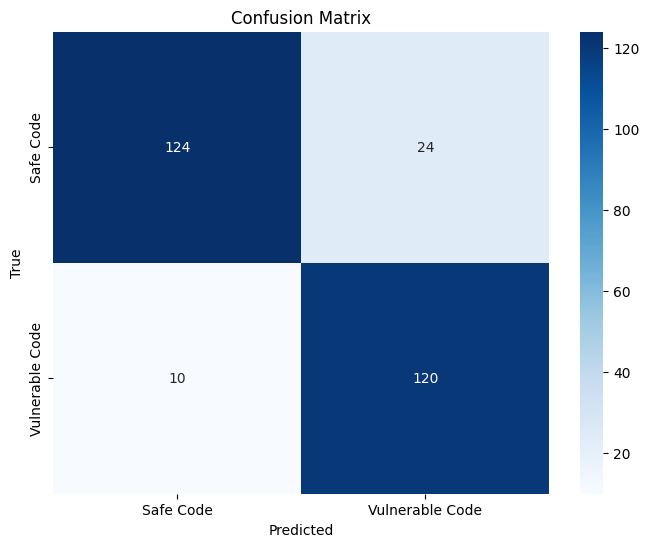

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

y_true = dataset['test']['label']

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(final_predictions)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import accuracy_score

# Accuracy of individual predictions
for i in range(5):
    accuracy = accuracy_score(y_true, y_preds[i])
    print(f"Accuracy of prompt {i+1} on test set: {accuracy:.4f}")

# Majority voting accuracy
majority_accuracy = accuracy_score(y_true, final_predictions)
print(f"Majority voting accuracy on test set: {majority_accuracy:.4f}")

# Inconsistent voting analysis
inconsistent_cases = [i for i, preds in enumerate(zip(*y_preds)) if len(set(preds)) > 1]
print(f"Number of inconsistent cases in test set: {len(inconsistent_cases)}")

Accuracy of prompt 1 on test set: 0.8705
Accuracy of prompt 2 on test set: 0.8705
Accuracy of prompt 3 on test set: 0.8777
Accuracy of prompt 4 on test set: 0.8777
Accuracy of prompt 5 on test set: 0.8741
Majority voting accuracy on test set: 0.8777
Number of inconsistent cases in test set: 9
